<h1 style="font-size:2.0rem; color:green;"> ESA CCI gap-filling effect study  </h1>  

<div class="alert alert-block alert-success"; background-color:red>  In this notebook, we intend to study ESA CCI gap-filling effect in six pixels containing the snow stations (Ifrane, Midelt, Tichki, M'goun, Tizi Touzna, and Oukaimeden) and trend studies over the period 1982-2018 </div> 

<h1 style="font-size:1.5rem; color:green;"> Load required libraries </h1> 

In [1]:
# autoreload reloads modules automatically before entering the execution of code typed at the IPython prompt
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import netCDF4 as nc
from netCDF4 import Dataset  
import matplotlib.pyplot as plt
import xarray as xr         
from scipy import stats
import pymannkendall as mk

In [2]:
# For parallelisation
from dask.distributed import Client
client = Client(n_workers=16, threads_per_worker=2, memory_limit='32GB')
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 16
Total threads: 32,Total memory: 476.84 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:49216,Workers: 16
Dashboard: http://127.0.0.1:8787/status,Total threads: 32
Started: Just now,Total memory: 476.84 GiB
Comm: tcp://127.0.0.1:49339,Total threads: 2
Dashboard: http://127.0.0.1:49346/status,Memory: 29.80 GiB
Nanny: tcp://127.0.0.1:49233,


<h1 style="font-size:1.5rem; color:green;"> Importing and preparing ESA CCI 
scfg gap-filled and original data</h1>

In [25]:
path1 = r'C:\Data\Snow\SCFG\Satellite\modified_data\V0\extracted_points'

IFR_scfg = pd.read_csv( path1 + r'\scfg_orig\scfg_orig_IFR.csv', sep=",") 
IFR_scfg_interp = pd.read_csv( path1 + r'\scfg_gf\scfg_gf_IFR.csv', sep=",")

MID_scfg = pd.read_csv( path1 + r'\scfg_orig\scfg_orig_MID.csv', sep=",") 
MID_scfg_interp = pd.read_csv( path1 + r'\scfg_gf\scfg_gf_MID.csv', sep=",")

TIC_scfg = pd.read_csv( path1 + r'\scfg_orig\scfg_orig_TIC.csv', sep=",") 
TIC_scfg_interp = pd.read_csv( path1 + r'\scfg_gf\scfg_gf_TIC.csv', sep=",")

MGN_scfg = pd.read_csv( path1 + r'\scfg_orig\scfg_orig_MGN.csv', sep=",") 
MGN_scfg_interp = pd.read_csv( path1 + r'\scfg_gf\scfg_gf_MGN.csv', sep=",")

TIZ_scfg = pd.read_csv( path1 + r'\scfg_orig\scfg_orig_TIZ.csv', sep=",") 
TIZ_scfg_interp = pd.read_csv( path1 + r'\scfg_gf\scfg_gf_TIZ.csv', sep=",")

OUK_scfg = pd.read_csv( path1 + r'\scfg_orig\scfg_orig_OUK.csv', sep=",") 
OUK_scfg_interp = pd.read_csv( path1 + r'\scfg_gf\scfg_gf_OUK.csv', sep=",")

# =======================================================================================================

path2 = r'C:\Data\Snow\SCFG\Satellite\modified_data\V0\extracted_points\cov' 

IFR_cov = pd.read_csv(path2+ '/cov_IFR.csv', sep=",")
MID_cov = pd.read_csv(path2+ '/cov_MID.csv', sep=",")
TIC_cov = pd.read_csv(path2+ '/cov_TIC.csv', sep=",")
MGN_cov = pd.read_csv(path2+ '/cov_MGN.csv', sep=",")
TIZ_cov = pd.read_csv(path2+ '/cov_TIZ.csv', sep=",")
OUK_cov = pd.read_csv(path2+ '/cov_OUK.csv', sep=",")

In [26]:
IFR_scfg

,date,scfg
0,01/01/1982,0
1,02/01/1982,0
2,03/01/1982,0
3,04/01/1982,0
4,05/01/1982,0
...,...,...
13341,26/12/2018,253
13342,27/12/2018,0
13343,28/12/2018,0
13344,29/12/2018,0


In [5]:
IFR_scfg_interp

,date,scfg_interp
0,01/01/1982,0.0
1,02/01/1982,0.0
2,03/01/1982,0.0
3,04/01/1982,0.0
4,05/01/1982,0.0
...,...,...
13417,27/12/2018,0.0
13418,28/12/2018,0.0
13419,29/12/2018,0.0
13420,30/12/2018,0.0


In [6]:
# Data coverage in each month before and after gap-filling 
IFR_cov

,date,cov,cov_interp
0,31/01/1982,16,20
1,28/02/1982,13,28
2,31/03/1982,21,31
3,30/04/1982,10,30
4,31/05/1982,10,24
...,...,...,...
436,31/08/2018,25,31
437,30/09/2018,13,30
438,31/10/2018,11,24
439,30/11/2018,14,27


<div class="alert alert-block alert-success"; background-color:red> We convert the date into a format recognized by the Pandas module </div> 

In [27]:
IFR_scfg['date'] = pd.to_datetime(IFR_scfg['date'], dayfirst=True, yearfirst=True)
IFR_scfg_interp['date'] = pd.to_datetime(IFR_scfg_interp['date'],  dayfirst=True, yearfirst=True)

MID_scfg['date'] = pd.to_datetime(MID_scfg['date'],  dayfirst=True, yearfirst=True)
MID_scfg_interp['date'] = pd.to_datetime(MID_scfg_interp['date'], dayfirst=True, yearfirst=True)

TIC_scfg['date'] = pd.to_datetime(TIC_scfg['date'], dayfirst=True, yearfirst=True)
TIC_scfg_interp['date'] = pd.to_datetime(TIC_scfg_interp['date'],  dayfirst=True, yearfirst=True)

MGN_scfg['date'] = pd.to_datetime(MGN_scfg['date'], dayfirst=True, yearfirst=True)
MGN_scfg_interp['date'] = pd.to_datetime(MGN_scfg_interp['date'], dayfirst=True, yearfirst=True)

TIZ_scfg['date'] = pd.to_datetime(TIZ_scfg['date'],  dayfirst=True, yearfirst=True)
TIZ_scfg_interp['date'] = pd.to_datetime(TIZ_scfg_interp['date'], dayfirst=True, yearfirst=True)

OUK_scfg['date'] = pd.to_datetime(OUK_scfg['date'], dayfirst=True, yearfirst=True)
OUK_scfg_interp['date'] = pd.to_datetime(OUK_scfg_interp['date'], dayfirst=True, yearfirst=True)

In [28]:
IFR_cov['date'] = pd.to_datetime(IFR_cov['date'], yearfirst=True)
MID_cov['date'] = pd.to_datetime(MID_cov['date'], yearfirst=True)
TIC_cov['date'] = pd.to_datetime(TIC_cov['date'], yearfirst=True)
MGN_cov['date'] = pd.to_datetime(MGN_cov['date'], yearfirst=True)
TIZ_cov['date'] = pd.to_datetime(TIZ_cov['date'], yearfirst=True)
OUK_cov['date'] = pd.to_datetime(OUK_cov['date'], yearfirst=True)

C:\Users\Hamid\AppData\Local\Temp\ipykernel_700\2000588832.py:1: UserWarning: Parsing '31/01/1982' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  IFR_cov['date'] = pd.to_datetime(IFR_cov['date'], yearfirst=True)
C:\Users\Hamid\AppData\Local\Temp\ipykernel_700\2000588832.py:1: UserWarning: Parsing '28/02/1982' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  IFR_cov['date'] = pd.to_datetime(IFR_cov['date'], yearfirst=True)
C:\Users\Hamid\AppData\Local\Temp\ipykernel_700\2000588832.py:1: UserWarning: Parsing '31/03/1982' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  IFR_cov['date'] = pd.to_datetime(IFR_cov['date'], yearfirst=True)
C:\Users\Hamid\AppData\Local\Temp\ipykernel_700\2000588832.py:1: UserWarning: Parsing '30/04/1982' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  IF

<div class="alert alert-block alert-success"; background-color:red> We convert the date into a standard format yyyy-mm-dd  </div> 

In [29]:
IFR_scfg['date'] = pd.to_datetime(IFR_scfg['date'], format='%Y-%m-%d')
IFR_scfg_interp['date'] = pd.to_datetime(IFR_scfg_interp['date'], format='%Y-%m-%d')

MID_scfg['date'] = pd.to_datetime(MID_scfg['date'], format='%Y-%m-%d')
MID_scfg_interp['date'] = pd.to_datetime(MID_scfg_interp['date'], format='%Y-%m-%d')
  
TIC_scfg['date'] = pd.to_datetime(TIC_scfg['date'], format='%Y-%m-%d')
TIC_scfg_interp['date'] = pd.to_datetime(TIC_scfg_interp['date'], format='%Y-%m-%d')

MGN_scfg['date'] = pd.to_datetime(MGN_scfg['date'], format='%Y-%m-%d')
MGN_scfg_interp['date'] = pd.to_datetime(MGN_scfg_interp['date'], format='%Y-%m-%d')

TIZ_scfg['date'] = pd.to_datetime(TIZ_scfg['date'], format='%Y-%m-%d')
TIZ_scfg_interp['date'] = pd.to_datetime(TIZ_scfg_interp['date'], format='%Y-%m-%d')
  
OUK_scfg['date'] = pd.to_datetime(OUK_scfg['date'], format='%Y-%m-%d')
OUK_scfg_interp['date'] = pd.to_datetime(OUK_scfg_interp['date'], format='%Y-%m-%d')

In [30]:
IFR_cov['date'] = pd.to_datetime(IFR_cov['date'], format='%Y-%m-%d')
MID_cov['date'] = pd.to_datetime(MID_cov['date'], format='%Y-%m-%d')
TIC_cov['date'] = pd.to_datetime(TIC_cov['date'], format='%Y-%m-%d')
MGN_cov['date'] = pd.to_datetime(MGN_cov['date'], format='%Y-%m-%d')
TIZ_cov['date'] = pd.to_datetime(TIZ_cov['date'], format='%Y-%m-%d')
OUK_cov['date'] = pd.to_datetime(OUK_cov['date'], format='%Y-%m-%d')

<div class="alert alert-block alert-success"; background-color:red> We put the date column as index  </div> 

In [31]:
IFR_scfg.set_index('date', inplace=True)
IFR_scfg_interp.set_index('date', inplace=True)

MID_scfg.set_index('date', inplace=True)
MID_scfg_interp.set_index('date', inplace=True)

TIC_scfg.set_index('date', inplace=True)
TIC_scfg_interp.set_index('date', inplace=True)

MGN_scfg.set_index('date', inplace=True)
MGN_scfg_interp.set_index('date', inplace=True)

TIZ_scfg.set_index('date', inplace=True)
TIZ_scfg_interp.set_index('date', inplace=True)

OUK_scfg.set_index('date', inplace=True)
OUK_scfg_interp.set_index('date', inplace=True)

In [32]:
IFR_cov.set_index('date', inplace=True)
MID_cov.set_index('date', inplace=True)
TIC_cov.set_index('date', inplace=True)
MGN_cov.set_index('date', inplace=True)
TIZ_cov.set_index('date', inplace=True)
OUK_cov.set_index('date', inplace=True)

<div class="alert alert-block alert-success"; background-color:red> Calculation of the monthly average number of days per month covered by the data  </div> 

In [33]:
IFR_cov_mean = IFR_cov.groupby(by=[IFR_cov.index.month]).mean()
MID_cov_mean = MID_cov.groupby(by=[MID_cov.index.month]).mean()
TIC_cov_mean = TIC_cov.groupby(by=[TIC_cov.index.month]).mean()
MGN_cov_mean = MGN_cov.groupby(by=[MGN_cov.index.month]).mean()
TIZ_cov_mean = TIZ_cov.groupby(by=[TIZ_cov.index.month]).mean()
OUK_cov_mean = OUK_cov.groupby(by=[OUK_cov.index.month]).mean()

<div class="alert alert-block alert-success"; background-color:red> We define index for the following dataframes </div> 

In [34]:
IFR_cov_mean.index = [0,1,2,3,4,5,6,7,8,9,10,11]
MID_cov_mean.index = [0,1,2,3,4,5,6,7,8,9,10,11]
TIC_cov_mean.index = [0,1,2,3,4,5,6,7,8,9,10,11]
MGN_cov_mean.index = [0,1,2,3,4,5,6,7,8,9,10,11]
TIZ_cov_mean.index = [0,1,2,3,4,5,6,7,8,9,10,11]
OUK_cov_mean.index = [0,1,2,3,4,5,6,7,8,9,10,11]

<div class="alert alert-block alert-success"; background-color:red> For the gap-fiiled data, we put all specific values which are higher than 100% to nan  </div> 

In [35]:
IFR_scfg.loc[IFR_scfg['scfg'] > 100, 'scfg'] = -9999
MID_scfg.loc[MID_scfg['scfg'] > 100, 'scfg'] = -9999
TIC_scfg.loc[TIC_scfg['scfg'] > 100, 'scfg'] = -9999
MGN_scfg.loc[MGN_scfg['scfg'] > 100, 'scfg'] = -9999
TIZ_scfg.loc[TIZ_scfg['scfg'] > 100, 'scfg'] = -9999
OUK_scfg.loc[OUK_scfg['scfg'] > 100, 'scfg'] = -9999

In [36]:
IFR_scfg_interp = IFR_scfg_interp.fillna(-9999)
MID_scfg_interp = MID_scfg_interp.fillna(-9999)
TIC_scfg_interp = TIC_scfg_interp.fillna(-9999)
MGN_scfg_interp = MGN_scfg_interp.fillna(-9999)
TIZ_scfg_interp = TIZ_scfg_interp.fillna(-9999)
OUK_scfg_interp = OUK_scfg_interp.fillna(-9999)

<div class="alert alert-block alert-success"; background-color:red> We run the following two cells, only if we want to view the time series  </div> 

In [16]:
IFR_scfg = IFR_scfg.replace(-9999, np.nan)
MID_scfg = MID_scfg.replace(-9999, np.nan)
TIC_scfg = TIC_scfg.replace(-9999, np.nan)
MGN_scfg = MGN_scfg.replace(-9999, np.nan)
TIZ_scfg = TIZ_scfg.replace(-9999, np.nan)
OUK_scfg = OUK_scfg.replace(-9999, np.nan)

In [17]:
MID_scfg = MID_scfg.reset_index()
IFR_scfg = IFR_scfg.reset_index()
TIC_scfg = TIC_scfg.reset_index()
MGN_scfg = MGN_scfg.reset_index()
TIZ_scfg = TIZ_scfg.reset_index()
OUK_scfg = OUK_scfg.reset_index()

<div class="alert alert-block alert-success"; background-color:red>  An auxiliary function for formatting of the figures  </div> 

In [18]:
def set_size(w,h, ax=None):
    """ w, h: width, height in inches """
    if not ax: ax=plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh)

<h1 style="font-size:1.5rem; color:green;"> Timeseries vizualisation </h1>

<div class="alert alert-block alert-success"; background-color:red>  Raw time series </div> 

In [19]:
pixels = [IFR_scfg, MID_scfg, TIC_scfg, MGN_scfg, TIZ_scfg, OUK_scfg]
pixels_gf = [IFR_scfg_interp, MID_scfg_interp, TIC_scfg_interp, MGN_scfg_interp, 
                   TIZ_scfg_interp, OUK_scfg_interp]

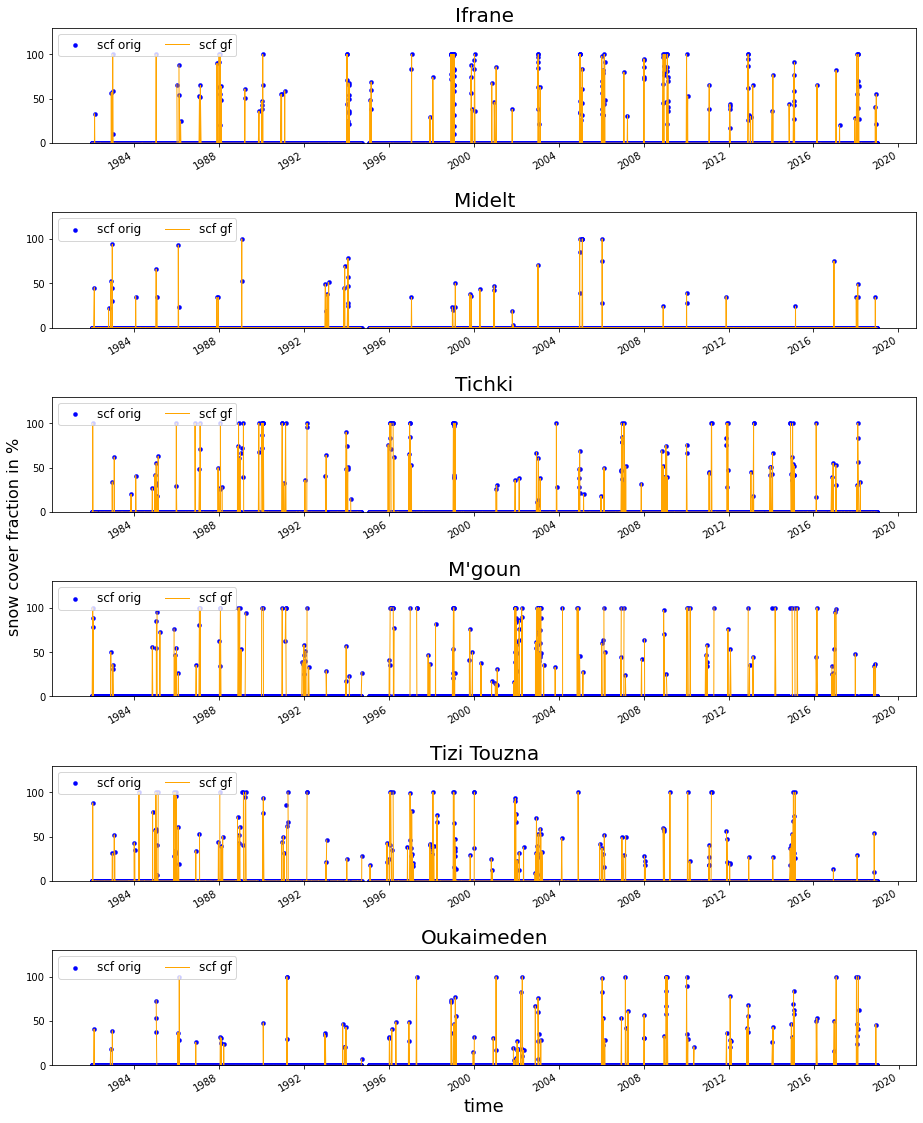

In [42]:
labels = ["Ifrane","Midelt","Tichki","M'goun","Tizi Touzna","Oukaimeden"]
fig, axs = plt.subplots(6,1)
plt.subplots_adjust(wspace=0.15,hspace=0.6)

# figure size
set_size(12,16)

for i in range(6):
    pixels[i].plot(ax = axs[i], x='date', y='scfg', kind='scatter', color='blue', fontsize=10, linewidth=0.1)   
    pixels_gf[i].plot(ax = axs[i], color='orange', linewidth=1)   
    axs[i].legend(labels=['scf orig','scf gf'], ncol=3, loc='upper left', fontsize=12)   
    axs[i].set_ylim(0,130)    
    axs[i].set_xlabel("", fontsize=12)     
    axs[i].set_ylabel("", fontsize=12)     
    axs[i].set_title(labels[i], fontsize=20) 
    
axs[5].set_xlabel("time", fontsize=18)
axs[3].set_ylabel("                                        snow cover fraction in %", fontsize=16) 
plt.savefig('timeseries_esa_cci_gf_nongf.png')

<h1 style="font-size:1.5rem; color:green;"> Comparison ESA CCI scfg gap-filled product - ESA CCI scfg non gap-filled product   </h1>

<div class="alert alert-block alert-success"; background-color:red> First, we calculate the climatological monthly 
    averages of the number of days with snow over land in the six pixels containing the six stations over the period 1982-2018 on homogeneous periods  </div> 

<h1 style="font-size:1.5rem; color:green;"> Ifrane </h1>

In [43]:
Snow_esa = IFR_scfg['scfg'].where(IFR_scfg['scfg'] > 0).groupby(by=[IFR_scfg.index.month,IFR_scfg.index.year]).count() 
Sum_esa = IFR_scfg['scfg'].where(IFR_scfg['scfg'] >= 0).groupby(by=[IFR_scfg.index.month,IFR_scfg.index.year]).count() 
Nan_esa = IFR_scfg['scfg'].where(IFR_scfg['scfg'] < 0).groupby(by=[IFR_scfg.index.month,IFR_scfg.index.year]).count()

Snow_esa_gf = IFR_scfg_interp['scfg_interp'].where(IFR_scfg_interp['scfg_interp'] > 0).groupby(by=[IFR_scfg_interp.index.month,IFR_scfg_interp.index.year]).count() 
Sum_esa_gf = IFR_scfg_interp['scfg_interp'].where(IFR_scfg_interp['scfg_interp'] >= 0).groupby(by=[IFR_scfg_interp.index.month,IFR_scfg_interp.index.year]).count() 
Nan_esa_gf = IFR_scfg_interp['scfg_interp'].where(IFR_scfg_interp['scfg_interp'] < 0).groupby(by=[IFR_scfg_interp.index.month,IFR_scfg_interp.index.year]).count()


years = [y for y in range(1982,2019)]
for mon in range(1,13):
    for year in years:
        try: 
            if Nan_esa[mon][year]>15:
                
                Nan_esa[mon][year] = -9999
                Snow_esa[mon][year] = -9999
                
                Nan_esa_gf[mon][year] = -9999
                Snow_esa_gf[mon][year] = -9999
                
        except KeyError:
            continue 

IFR_disp = pd.DataFrame(columns=['disp'])
L=[]
for i in range(1,13):
    L.append(Snow_esa[i].where(Snow_esa[i] >= 0).count())
    
IFR_disp['disp'] = L
IFR_disp.index = [0,1,2,3,4,5,6,7,8,9,10,11]     
    

Nan_esa = Nan_esa.replace(-9999, np.nan)
Snow_esa = Snow_esa.replace(-9999, np.nan)

Nan_esa_gf = Nan_esa_gf.replace(-9999, np.nan)
Snow_esa_gf = Snow_esa_gf.replace(-9999, np.nan)
                  
IFR_scfg_Sdays =   Snow_esa + Snow_esa*Nan_esa/Sum_esa
IFR_scfg_std = IFR_scfg_Sdays.groupby('date').std().to_list()
IFR_scfg_std = [str(np.around(std, decimals = 2)) for std in IFR_scfg_std]
IFR_scfg_ext = [IFR_scfg_Sdays.groupby('date').mean() - IFR_scfg_Sdays.groupby('date').min(), IFR_scfg_Sdays.groupby('date').max() - IFR_scfg_Sdays.groupby('date').mean()] 
IFR_scfg_Sdays_mean = IFR_scfg_Sdays.groupby('date').mean()
            
IFR_scfg_interp_Sdays =   Snow_esa_gf + Snow_esa_gf*Nan_esa_gf/Sum_esa_gf
IFR_scfg_interp_std = IFR_scfg_interp_Sdays.groupby('date').std().to_list()
IFR_scfg_interp_std = [str(np.around(std, decimals = 2)) for std in IFR_scfg_interp_std]
IFR_scfg_interp_ext = [IFR_scfg_interp_Sdays.groupby('date').mean() - IFR_scfg_interp_Sdays.groupby('date').min(), IFR_scfg_interp_Sdays.groupby('date').max() - IFR_scfg_interp_Sdays.groupby('date').mean()] 
IFR_scfg_interp_Sdays_mean = IFR_scfg_interp_Sdays.groupby('date').mean()            

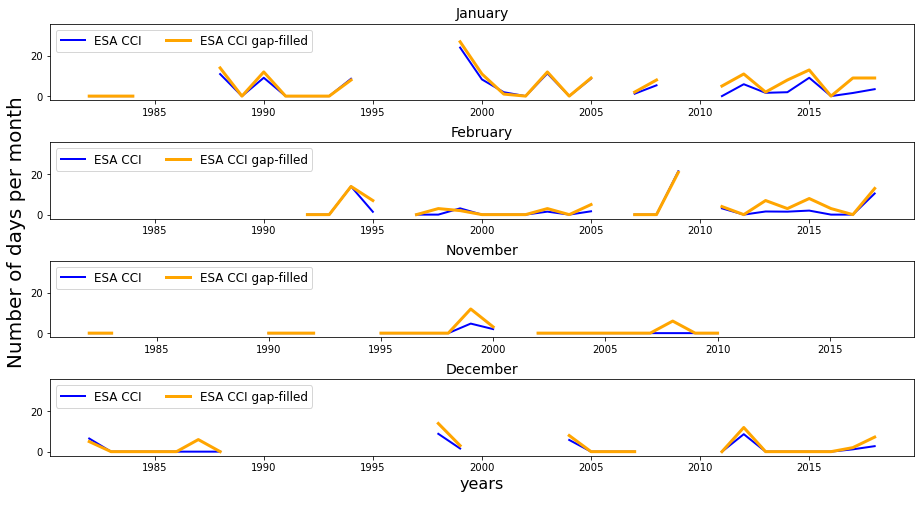

In [45]:
labels = ["January","February","November","December"] 
fig, axs = plt.subplots(4,1)                                                      
plt.subplots_adjust(wspace=0.3,hspace=0.55) 

mons = [1,2,11,12] 
set_size(12,6)
for i in range(4):   
    IFR_scfg_Sdays[mons[i]].plot(ax=axs[i], color='blue', linewidth=2, xlabel="")  
    IFR_scfg_interp_Sdays[mons[i]].plot(ax=axs[i], color='orange', linewidth=3, xlabel="") 
    
    axs[i].legend(labels = ["ESA CCI","ESA CCI gap-filled"], loc='upper left', fontsize = 12, ncol=2) 
    axs[i].set_title(labels[i], fontsize = 14) 
    axs[i].set_ylim(-2,36) 
    
axs[3].set_xlabel("years", fontsize=16)                                       
axs[2].set_ylabel("                     Number of days per month", fontsize=20)
                                                                                                 
plt.savefig('day_snow_monthly_values_IFR.png')                                                                                                    

<h1 style="font-size:1.5rem; color:green;"> Midelt </h1>

In [46]:
Snow_esa = MID_scfg['scfg'].where(MID_scfg['scfg'] > 0).groupby(by=[MID_scfg.index.month,MID_scfg.index.year]).count() 
Sum_esa = MID_scfg['scfg'].where(MID_scfg['scfg'] >= 0).groupby(by=[MID_scfg.index.month,MID_scfg.index.year]).count() 
Nan_esa = MID_scfg['scfg'].where(MID_scfg['scfg'] < 0).groupby(by=[MID_scfg.index.month,MID_scfg.index.year]).count()

Snow_esa_gf = MID_scfg_interp['scfg_interp'].where(MID_scfg_interp['scfg_interp'] > 0).groupby(by=[MID_scfg_interp.index.month,MID_scfg_interp.index.year]).count() 
Sum_esa_gf = MID_scfg_interp['scfg_interp'].where(MID_scfg_interp['scfg_interp'] >= 0).groupby(by=[MID_scfg_interp.index.month,MID_scfg_interp.index.year]).count() 
Nan_esa_gf = MID_scfg_interp['scfg_interp'].where(MID_scfg_interp['scfg_interp'] < 0).groupby(by=[MID_scfg_interp.index.month,MID_scfg_interp.index.year]).count()


years = [y for y in range(1982,2019)]
for mon in range(1,13):
    for year in years:
        try: 
            if Nan_esa[mon][year]>15:
                
                Nan_esa[mon][year] = -9999
                Snow_esa[mon][year] = -9999
                
                Nan_esa_gf[mon][year] = -9999
                Snow_esa_gf[mon][year] = -9999
                
        except KeyError:
            continue 

MID_disp = pd.DataFrame(columns=['disp'])
L=[]
for i in range(1,13):
    L.append(Snow_esa[i].where(Snow_esa[i] >= 0).count())
    
MID_disp['disp'] = L
MID_disp.index = [0,1,2,3,4,5,6,7,8,9,10,11]

Nan_esa = Nan_esa.replace(-9999, np.nan)
Snow_esa = Snow_esa.replace(-9999, np.nan)

Nan_esa_gf = Nan_esa_gf.replace(-9999, np.nan)
Snow_esa_gf = Snow_esa_gf.replace(-9999, np.nan)
           
MID_scfg_Sdays =   Snow_esa + Snow_esa*Nan_esa/Sum_esa
MID_scfg_std = MID_scfg_Sdays.groupby('date').std().to_list()
MID_scfg_std = [str(np.around(std, decimals = 2)) for std in MID_scfg_std]
MID_scfg_ext = [MID_scfg_Sdays.groupby('date').mean() - MID_scfg_Sdays.groupby('date').min(), MID_scfg_Sdays.groupby('date').max() - MID_scfg_Sdays.groupby('date').mean()] 
MID_scfg_Sdays_mean = MID_scfg_Sdays.groupby('date').mean()
            
MID_scfg_interp_Sdays =   Snow_esa_gf + Snow_esa_gf*Nan_esa_gf/Sum_esa_gf
MID_scfg_interp_std = MID_scfg_interp_Sdays.groupby('date').std().to_list()
MID_scfg_interp_std = [str(np.around(std, decimals = 2)) for std in MID_scfg_interp_std]
MID_scfg_interp_ext = [MID_scfg_interp_Sdays.groupby('date').mean() - MID_scfg_interp_Sdays.groupby('date').min(), MID_scfg_interp_Sdays.groupby('date').max() - MID_scfg_interp_Sdays.groupby('date').mean()] 
MID_scfg_interp_Sdays_mean = MID_scfg_interp_Sdays.groupby('date').mean()            

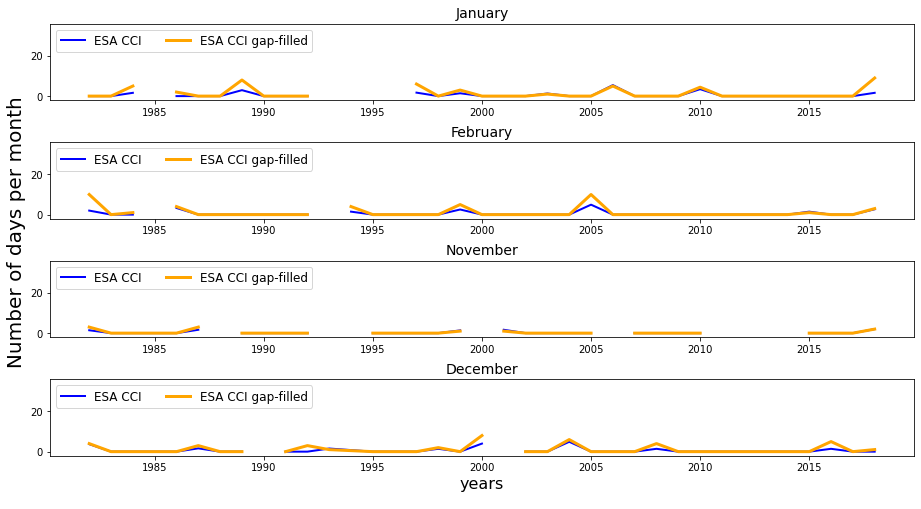

In [47]:
labels = ["January","February","November","December"] 
fig, axs = plt.subplots(4,1)                                                      
plt.subplots_adjust(wspace=0.3,hspace=0.55) 

mons = [1,2,11,12] 
set_size(12,6)
for i in range(4):   
    MID_scfg_Sdays[mons[i]].plot(ax=axs[i], color='blue', linewidth=2, xlabel="")  
    MID_scfg_interp_Sdays[mons[i]].plot(ax=axs[i], color='orange', linewidth=3, xlabel="") 
    
    axs[i].legend(labels = ["ESA CCI","ESA CCI gap-filled"], loc='upper left', fontsize = 12, ncol=2) 
    axs[i].set_title(labels[i], fontsize = 14) 
    axs[i].set_ylim(-2,36) 
    
axs[3].set_xlabel("years", fontsize=16)                                       
axs[2].set_ylabel("                     Number of days per month", fontsize=20)
                                                                                                 
plt.savefig('day_snow_monthly_values_MID.png') 

<h1 style="font-size:1.5rem; color:green;"> Tichki </h1>

In [48]:
Snow_esa = TIC_scfg['scfg'].where(TIC_scfg['scfg'] > 0).groupby(by=[TIC_scfg.index.month,TIC_scfg.index.year]).count() 
Sum_esa = TIC_scfg['scfg'].where(TIC_scfg['scfg'] >= 0).groupby(by=[TIC_scfg.index.month,TIC_scfg.index.year]).count() 
Nan_esa = TIC_scfg['scfg'].where(TIC_scfg['scfg'] < 0).groupby(by=[TIC_scfg.index.month,TIC_scfg.index.year]).count()

Snow_esa_gf = TIC_scfg_interp['scfg_interp'].where(TIC_scfg_interp['scfg_interp'] > 0).groupby(by=[TIC_scfg_interp.index.month,TIC_scfg_interp.index.year]).count() 
Sum_esa_gf = TIC_scfg_interp['scfg_interp'].where(TIC_scfg_interp['scfg_interp'] >= 0).groupby(by=[TIC_scfg_interp.index.month,TIC_scfg_interp.index.year]).count() 
Nan_esa_gf = TIC_scfg_interp['scfg_interp'].where(TIC_scfg_interp['scfg_interp'] < 0).groupby(by=[TIC_scfg_interp.index.month,TIC_scfg_interp.index.year]).count()


years = [y for y in range(1982,2019)]
for mon in range(1,13):
    for year in years:
        try: 
            if Nan_esa[mon][year]>15:
                
                Nan_esa[mon][year] = -9999
                Snow_esa[mon][year] = -9999
                
                Nan_esa_gf[mon][year] = -9999
                Snow_esa_gf[mon][year] = -9999
                
        except KeyError:
            continue 

TIC_disp = pd.DataFrame(columns=['disp'])
L=[]
for i in range(1,13):
    L.append(Snow_esa[i].where(Snow_esa[i] >= 0).count())
    
TIC_disp['disp'] = L
TIC_disp.index = [0,1,2,3,4,5,6,7,8,9,10,11]

Nan_esa = Nan_esa.replace(-9999, np.nan)
Snow_esa = Snow_esa.replace(-9999, np.nan)

Nan_esa_gf = Nan_esa_gf.replace(-9999, np.nan)
Snow_esa_gf = Snow_esa_gf.replace(-9999, np.nan)
           
TIC_scfg_Sdays =   Snow_esa + Snow_esa*Nan_esa/Sum_esa
TIC_scfg_std = TIC_scfg_Sdays.groupby('date').std().to_list()
TIC_scfg_std = [str(np.around(std, decimals = 2)) for std in TIC_scfg_std]
TIC_scfg_ext = [TIC_scfg_Sdays.groupby('date').mean() - TIC_scfg_Sdays.groupby('date').min(), TIC_scfg_Sdays.groupby('date').max() - TIC_scfg_Sdays.groupby('date').mean()] 
TIC_scfg_Sdays_mean = TIC_scfg_Sdays.groupby('date').mean()
            
TIC_scfg_interp_Sdays =   Snow_esa_gf + Snow_esa_gf*Nan_esa_gf/Sum_esa_gf
TIC_scfg_interp_std = TIC_scfg_interp_Sdays.groupby('date').std().to_list()
TIC_scfg_interp_std = [str(np.around(std, decimals = 2)) for std in TIC_scfg_interp_std]
TIC_scfg_interp_ext = [TIC_scfg_interp_Sdays.groupby('date').mean() - TIC_scfg_interp_Sdays.groupby('date').min(), TIC_scfg_interp_Sdays.groupby('date').max() - TIC_scfg_interp_Sdays.groupby('date').mean()] 
TIC_scfg_interp_Sdays_mean = TIC_scfg_interp_Sdays.groupby('date').mean()            

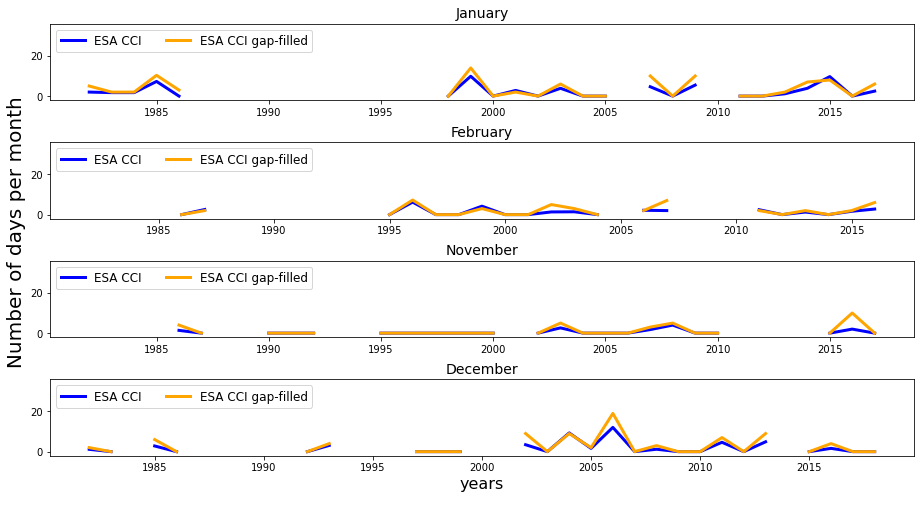

In [49]:
labels = ["January","February","November","December"] 
fig, axs = plt.subplots(4,1)                                                      
plt.subplots_adjust(wspace=0.3,hspace=0.55) 

mons = [1,2,11,12] 
set_size(12,6)
for i in range(4):   
    TIC_scfg_Sdays[mons[i]].plot(ax=axs[i], color='blue', linewidth=3, xlabel="")  
    TIC_scfg_interp_Sdays[mons[i]].plot(ax=axs[i], color='orange', linewidth=3, xlabel="") 
    
    axs[i].legend(labels = ["ESA CCI","ESA CCI gap-filled"], loc='upper left', fontsize = 12, ncol=2) 
    axs[i].set_title(labels[i], fontsize = 14) 
    axs[i].set_ylim(-2,36) 
    
axs[3].set_xlabel("years", fontsize=16)                                       
axs[2].set_ylabel("                     Number of days per month", fontsize=20)
                                                                                                 
plt.savefig('day_snow_monthly_values_TIC.png') 

<h1 style="font-size:1.5rem; color:green;"> M'goun </h1>

In [50]:
Snow_esa = MGN_scfg['scfg'].where(MGN_scfg['scfg'] > 0).groupby(by=[MGN_scfg.index.month,MGN_scfg.index.year]).count() 
Sum_esa = MGN_scfg['scfg'].where(MGN_scfg['scfg'] >= 0).groupby(by=[MGN_scfg.index.month,MGN_scfg.index.year]).count() 
Nan_esa = MGN_scfg['scfg'].where(MGN_scfg['scfg'] < 0).groupby(by=[MGN_scfg.index.month,MGN_scfg.index.year]).count()

Snow_esa_gf = MGN_scfg_interp['scfg_interp'].where(MGN_scfg_interp['scfg_interp'] > 0).groupby(by=[MGN_scfg_interp.index.month,MGN_scfg_interp.index.year]).count() 
Sum_esa_gf = MGN_scfg_interp['scfg_interp'].where(MGN_scfg_interp['scfg_interp'] >= 0).groupby(by=[MGN_scfg_interp.index.month,MGN_scfg_interp.index.year]).count() 
Nan_esa_gf = MGN_scfg_interp['scfg_interp'].where(MGN_scfg_interp['scfg_interp'] < 0).groupby(by=[MGN_scfg_interp.index.month,MGN_scfg_interp.index.year]).count()


years = [y for y in range(1982,2019)]
for mon in range(1,13):
    for year in years:
        try: 
            if Nan_esa[mon][year]>15:
                
                Nan_esa[mon][year] = -9999
                Snow_esa[mon][year] = -9999
                
                Nan_esa_gf[mon][year] = -9999
                Snow_esa_gf[mon][year] = -9999
                
        except KeyError:
            continue 

MGN_disp = pd.DataFrame(columns=['disp'])
L=[]
for i in range(1,13):
    L.append(Snow_esa[i].where(Snow_esa[i] >= 0).count())
    
MGN_disp['disp'] = L
MGN_disp.index = [0,1,2,3,4,5,6,7,8,9,10,11]

Nan_esa = Nan_esa.replace(-9999, np.nan)
Snow_esa = Snow_esa.replace(-9999, np.nan)

Nan_esa_gf = Nan_esa_gf.replace(-9999, np.nan)
Snow_esa_gf = Snow_esa_gf.replace(-9999, np.nan)
           
MGN_scfg_Sdays =   Snow_esa + Snow_esa*Nan_esa/Sum_esa
MGN_scfg_std = MGN_scfg_Sdays.groupby('date').std().to_list()
MGN_scfg_std = [str(np.around(std, decimals = 2)) for std in MGN_scfg_std]
MGN_scfg_ext = [MGN_scfg_Sdays.groupby('date').mean() - MGN_scfg_Sdays.groupby('date').min(), MGN_scfg_Sdays.groupby('date').max() - MGN_scfg_Sdays.groupby('date').mean()] 
MGN_scfg_Sdays_mean = MGN_scfg_Sdays.groupby('date').mean()
            
MGN_scfg_interp_Sdays =   Snow_esa_gf + Snow_esa_gf*Nan_esa_gf/Sum_esa_gf
MGN_scfg_interp_std = MGN_scfg_interp_Sdays.groupby('date').std().to_list()
MGN_scfg_interp_std = [str(np.around(std, decimals = 2)) for std in MGN_scfg_interp_std]
MGN_scfg_interp_ext = [MGN_scfg_interp_Sdays.groupby('date').mean() - MGN_scfg_interp_Sdays.groupby('date').min(), MGN_scfg_interp_Sdays.groupby('date').max() - MGN_scfg_interp_Sdays.groupby('date').mean()] 
MGN_scfg_interp_Sdays_mean = MGN_scfg_interp_Sdays.groupby('date').mean()            

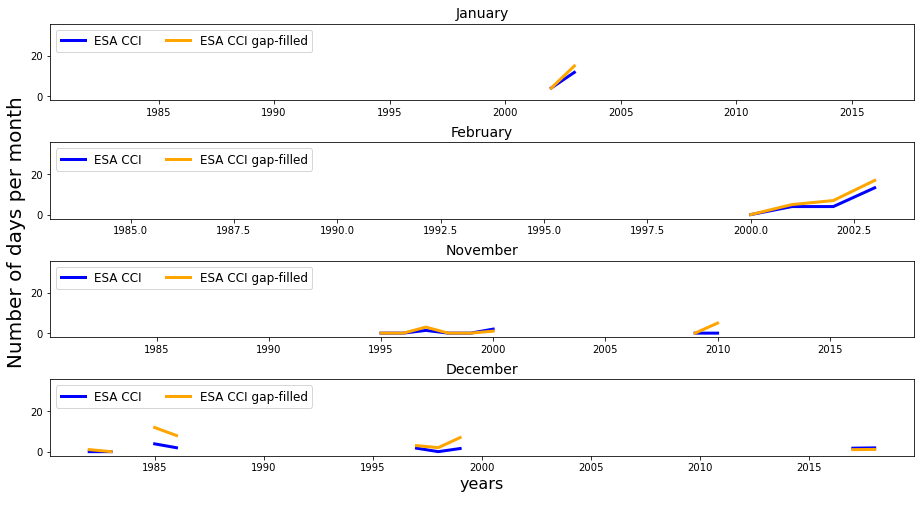

In [51]:
labels = ["January","February","November","December"] 
fig, axs = plt.subplots(4,1)                                                      
plt.subplots_adjust(wspace=0.3,hspace=0.55) 

mons = [1,2,11,12] 
set_size(12,6)
for i in range(4):   
    MGN_scfg_Sdays[mons[i]].plot(ax=axs[i], color='blue', linewidth=3, xlabel="")  
    MGN_scfg_interp_Sdays[mons[i]].plot(ax=axs[i], color='orange', linewidth=3, xlabel="") 
    
    axs[i].legend(labels = ["ESA CCI","ESA CCI gap-filled"], loc='upper left', fontsize = 12, ncol=2) 
    axs[i].set_title(labels[i], fontsize = 14) 
    axs[i].set_ylim(-2,36) 
    
axs[3].set_xlabel("years", fontsize=16)                                       
axs[2].set_ylabel("                     Number of days per month", fontsize=20)
                                                                                                 
plt.savefig('day_snow_monthly_values_MGN.png') 

<h1 style="font-size:1.5rem; color:green;"> Tizi Touzna </h1>

In [52]:
Snow_esa = TIZ_scfg['scfg'].where(TIZ_scfg['scfg'] > 0).groupby(by=[TIZ_scfg.index.month,TIZ_scfg.index.year]).count() 
Sum_esa = TIZ_scfg['scfg'].where(TIZ_scfg['scfg'] >= 0).groupby(by=[TIZ_scfg.index.month,TIZ_scfg.index.year]).count() 
Nan_esa = TIZ_scfg['scfg'].where(TIZ_scfg['scfg'] < 0).groupby(by=[TIZ_scfg.index.month,TIZ_scfg.index.year]).count()

Snow_esa_gf = TIZ_scfg_interp['scfg_interp'].where(TIZ_scfg_interp['scfg_interp'] > 0).groupby(by=[TIZ_scfg_interp.index.month,TIZ_scfg_interp.index.year]).count() 
Sum_esa_gf = TIZ_scfg_interp['scfg_interp'].where(TIZ_scfg_interp['scfg_interp'] >= 0).groupby(by=[TIZ_scfg_interp.index.month,TIZ_scfg_interp.index.year]).count() 
Nan_esa_gf = TIZ_scfg_interp['scfg_interp'].where(TIZ_scfg_interp['scfg_interp'] < 0).groupby(by=[TIZ_scfg_interp.index.month,TIZ_scfg_interp.index.year]).count()


years = [y for y in range(1982,2019)]
for mon in range(1,13):
    for year in years:
        try: 
            if Nan_esa[mon][year]>15:
                
                Nan_esa[mon][year] = -9999
                Snow_esa[mon][year] = -9999
                
                Nan_esa_gf[mon][year] = -9999
                Snow_esa_gf[mon][year] = -9999
                
        except KeyError:
            continue 

TIZ_disp = pd.DataFrame(columns=['disp'])
L=[]
for i in range(1,13):
    L.append(Snow_esa[i].where(Snow_esa[i] >= 0).count())
    
TIZ_disp['disp'] = L
TIZ_disp.index = [0,1,2,3,4,5,6,7,8,9,10,11]

Nan_esa = Nan_esa.replace(-9999, np.nan)
Snow_esa = Snow_esa.replace(-9999, np.nan)

Nan_esa_gf = Nan_esa_gf.replace(-9999, np.nan)
Snow_esa_gf = Snow_esa_gf.replace(-9999, np.nan)
         
TIZ_scfg_Sdays =   Snow_esa + Snow_esa*Nan_esa/Sum_esa
TIZ_scfg_std = TIZ_scfg_Sdays.groupby('date').std().to_list()
TIZ_scfg_std = [str(np.around(std, decimals = 2)) for std in TIZ_scfg_std]
TIZ_scfg_ext = [TIZ_scfg_Sdays.groupby('date').mean() - TIZ_scfg_Sdays.groupby('date').min(), TIZ_scfg_Sdays.groupby('date').max() - TIZ_scfg_Sdays.groupby('date').mean()] 
TIZ_scfg_Sdays_mean = TIZ_scfg_Sdays.groupby('date').mean()
            
TIZ_scfg_interp_Sdays =   Snow_esa_gf + Snow_esa_gf*Nan_esa_gf/Sum_esa_gf
TIZ_scfg_interp_std = TIZ_scfg_interp_Sdays.groupby('date').std().to_list()
TIZ_scfg_interp_std = [str(np.around(std, decimals = 2)) for std in TIZ_scfg_interp_std]
TIZ_scfg_interp_ext = [TIZ_scfg_interp_Sdays.groupby('date').mean() - TIZ_scfg_interp_Sdays.groupby('date').min(), TIZ_scfg_interp_Sdays.groupby('date').max() - TIZ_scfg_interp_Sdays.groupby('date').mean()] 
TIZ_scfg_interp_Sdays_mean = TIZ_scfg_interp_Sdays.groupby('date').mean()            

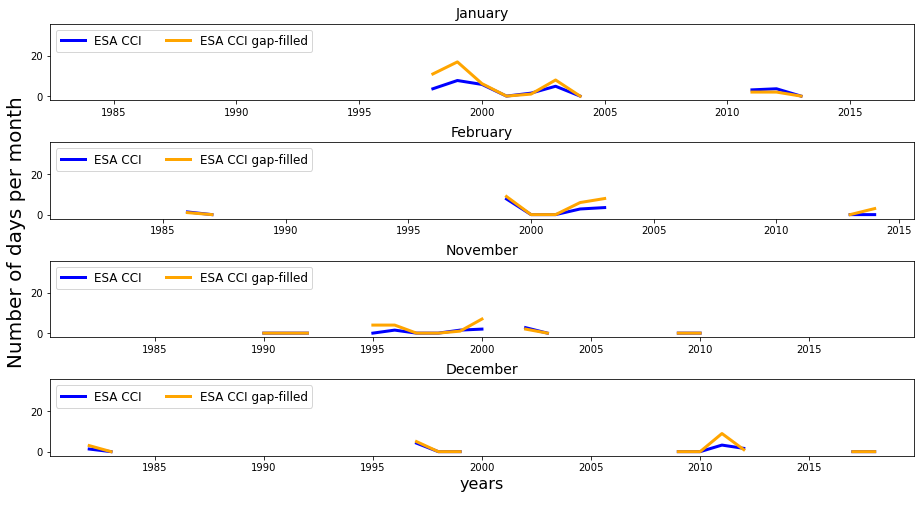

In [53]:
labels = ["January","February","November","December"] 
fig, axs = plt.subplots(4,1)                                                      
plt.subplots_adjust(wspace=0.3,hspace=0.55) 

mons = [1,2,11,12] 
set_size(12,6)
for i in range(4):   
    TIZ_scfg_Sdays[mons[i]].plot(ax=axs[i], color='blue', linewidth=3, xlabel="")  
    TIZ_scfg_interp_Sdays[mons[i]].plot(ax=axs[i], color='orange', linewidth=3, xlabel="") 
    
    axs[i].legend(labels = ["ESA CCI","ESA CCI gap-filled"], loc='upper left', fontsize = 12, ncol=2) 
    axs[i].set_title(labels[i], fontsize = 14) 
    axs[i].set_ylim(-2,36) 
    
axs[3].set_xlabel("years", fontsize=16)                                       
axs[2].set_ylabel("                     Number of days per month", fontsize=20)
                                                                                                 
plt.savefig('day_snow_monthly_values_TIZ.png') 

<h1 style="font-size:1.5rem; color:green;"> Oukaimeden </h1>

In [54]:
Snow_esa = OUK_scfg['scfg'].where(OUK_scfg['scfg'] > 0).groupby(by=[OUK_scfg.index.month,OUK_scfg.index.year]).count() 
Sum_esa = OUK_scfg['scfg'].where(OUK_scfg['scfg'] >= 0).groupby(by=[OUK_scfg.index.month,OUK_scfg.index.year]).count() 
Nan_esa = OUK_scfg['scfg'].where(OUK_scfg['scfg'] < 0).groupby(by=[OUK_scfg.index.month,OUK_scfg.index.year]).count()

Snow_esa_gf = OUK_scfg_interp['scfg_interp'].where(OUK_scfg_interp['scfg_interp'] > 0).groupby(by=[OUK_scfg_interp.index.month,OUK_scfg_interp.index.year]).count() 
Sum_esa_gf = OUK_scfg_interp['scfg_interp'].where(OUK_scfg_interp['scfg_interp'] >= 0).groupby(by=[OUK_scfg_interp.index.month,OUK_scfg_interp.index.year]).count() 
Nan_esa_gf = OUK_scfg_interp['scfg_interp'].where(OUK_scfg_interp['scfg_interp'] < 0).groupby(by=[OUK_scfg_interp.index.month,OUK_scfg_interp.index.year]).count()


years = [y for y in range(1982,2019)]
for mon in range(1,13):
    for year in years:
        try: 
            if Nan_esa[mon][year]>15:
                
                Nan_esa[mon][year] = -9999
                Snow_esa[mon][year] = -9999
                
                Nan_esa_gf[mon][year] = -9999
                Snow_esa_gf[mon][year] = -9999
                
        except KeyError:
            continue 

OUK_disp = pd.DataFrame(columns=['disp'])
L=[]
for i in range(1,13):
    L.append(Snow_esa[i].where(Snow_esa[i] >= 0).count())
    
OUK_disp['disp'] = L
OUK_disp.index = [0,1,2,3,4,5,6,7,8,9,10,11]

Nan_esa = Nan_esa.replace(-9999, np.nan)
Snow_esa = Snow_esa.replace(-9999, np.nan)

Nan_esa_gf = Nan_esa_gf.replace(-9999, np.nan)
Snow_esa_gf = Snow_esa_gf.replace(-9999, np.nan)
         
OUK_scfg_Sdays =   Snow_esa + Snow_esa*Nan_esa/Sum_esa
OUK_scfg_std = OUK_scfg_Sdays.groupby('date').std().to_list()
OUK_scfg_std = [str(np.around(std, decimals = 2)) for std in OUK_scfg_std]
OUK_scfg_ext = [OUK_scfg_Sdays.groupby('date').mean() - OUK_scfg_Sdays.groupby('date').min(), OUK_scfg_Sdays.groupby('date').max() - OUK_scfg_Sdays.groupby('date').mean()] 
OUK_scfg_Sdays_mean = OUK_scfg_Sdays.groupby('date').mean()
            
OUK_scfg_interp_Sdays =   Snow_esa_gf + Snow_esa_gf*Nan_esa_gf/Sum_esa_gf
OUK_scfg_interp_std = OUK_scfg_interp_Sdays.groupby('date').std().to_list()
OUK_scfg_interp_std = [str(np.around(std, decimals = 2)) for std in OUK_scfg_interp_std]
OUK_scfg_interp_ext = [OUK_scfg_interp_Sdays.groupby('date').mean() - OUK_scfg_interp_Sdays.groupby('date').min(), OUK_scfg_interp_Sdays.groupby('date').max() - OUK_scfg_interp_Sdays.groupby('date').mean()] 
OUK_scfg_interp_Sdays_mean = OUK_scfg_interp_Sdays.groupby('date').mean()            

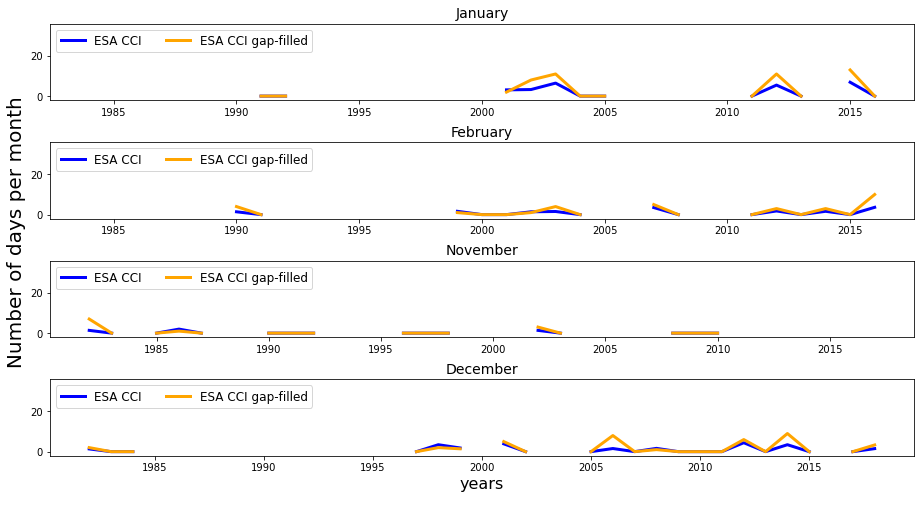

In [55]:
labels = ["January","February","November","December"] 
fig, axs = plt.subplots(4,1)                                                      
plt.subplots_adjust(wspace=0.3,hspace=0.55) 

mons = [1,2,11,12] 
set_size(12,6)
for i in range(4):   
    OUK_scfg_Sdays[mons[i]].plot(ax=axs[i], color='blue', linewidth=3, xlabel="")  
    OUK_scfg_interp_Sdays[mons[i]].plot(ax=axs[i], color='orange', linewidth=3, xlabel="") 
    
    axs[i].legend(labels = ["ESA CCI","ESA CCI gap-filled"], loc='upper left', fontsize = 12, ncol=2) 
    axs[i].set_title(labels[i], fontsize = 14) 
    axs[i].set_ylim(-2,36) 
    
axs[3].set_xlabel("years", fontsize=16)                                       
axs[2].set_ylabel("                     Number of days per month", fontsize=20)
                                                                                                 
plt.savefig('day_snow_monthly_values_OUK.png') 

<div class="alert alert-block alert-success"; background-color:red>  Now we prepare the dataframes to be plotted  </div> 

In [67]:
ifr = pd.concat([IFR_scfg_Sdays_mean, IFR_scfg_interp_Sdays_mean], axis=1)
mid = pd.concat([MID_scfg_Sdays_mean, MID_scfg_interp_Sdays_mean], axis=1)
tic = pd.concat([TIC_scfg_Sdays_mean, TIC_scfg_interp_Sdays_mean], axis=1)
mgn = pd.concat([ MGN_scfg_Sdays_mean, MGN_scfg_interp_Sdays_mean], axis=1)
tiz = pd.concat([ TIZ_scfg_Sdays_mean, TIZ_scfg_interp_Sdays_mean], axis=1)
ouk = pd.concat([ OUK_scfg_Sdays_mean, OUK_scfg_interp_Sdays_mean], axis=1)

Text(0, 0.5, 'Number of days per month')

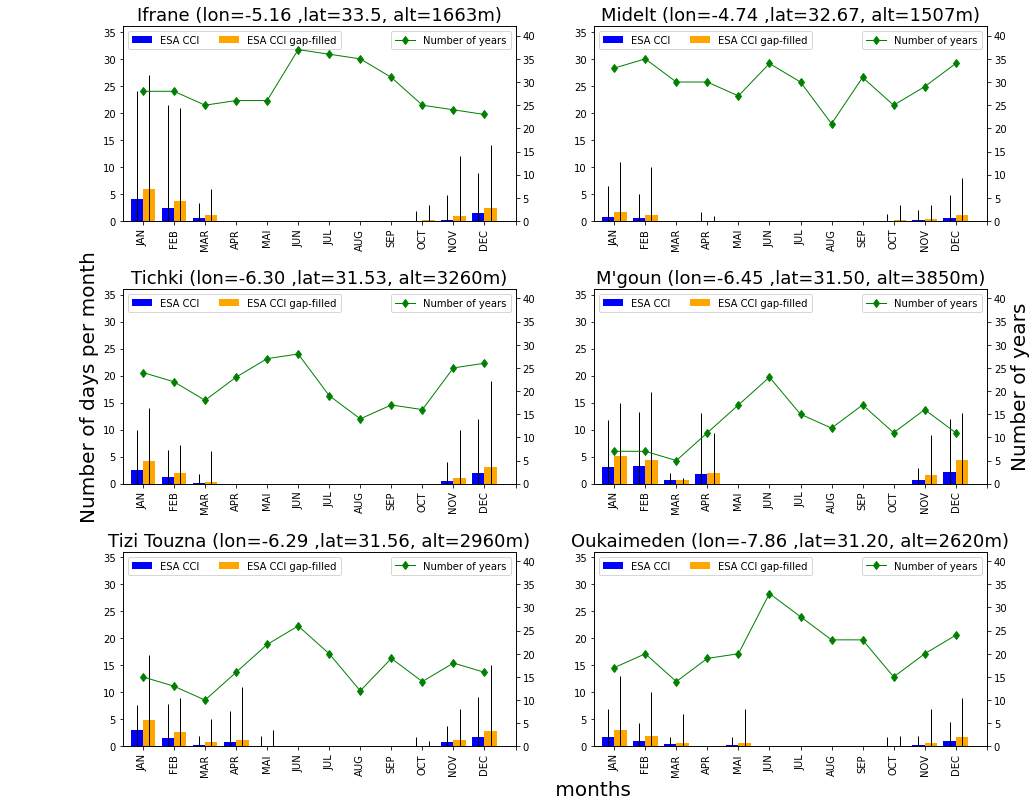

In [68]:
fig, axs=plt.subplots(3,2) 
# We fix the spaces between the subfigures
plt.subplots_adjust(wspace=0.2,hspace=0.35)

# We fix the size of figure
set_size(12,10)     

, female, width=0.4
c1 = 'blue'  
c2 = 'orange'
c3 = 'green'

ax = axs[0][0]
ifr.plot.bar(yerr=[IFR_scfg_ext,IFR_scfg_interp_ext], ax=ax, width=0.8, color=[c1, c2], grid=False, error_kw=dict(ecolor='black',elinewidth=1))
ax.set_xlabel("", fontsize=10) 
ax.legend(labels = ["ESA CCI","ESA CCI gap-filled"], loc='upper left', fontsize = 10, ncol=3)
ax.set_title("Ifrane (lon=-5.16 ,lat=33.5, alt=1663m)", fontsize = 18)
ax.set_ylim(0,36)


ax2 = ax.twinx()

IFR_disp.plot.line(ax=ax2, color=c3, marker='d', linewidth=1)
ax2.legend(labels = ["Number of years"], loc='upper right', fontsize = 10, ncol=2)  
ax2.set_ylim(0,42)
plt.xticks(ticks=[0,1,2,3,4,5,6,7,8,9,10,11,12], labels=["JAN","FEB","MAR","APR","MAI","JUN","JUL","AUG","SEP","OCT","NOV","DEC",""], fontsize=8)
#=============================== Midelt ===========================================

ax = axs[0][1]
mid.plot.bar(yerr=[MID_scfg_ext,MID_scfg_interp_ext], ax=ax, width=0.8, color=[c1, c2], grid=False, error_kw=dict(ecolor='black',elinewidth=1))
ax.set_xlabel("", fontsize=10) 
ax.legend(labels = ["ESA CCI","ESA CCI gap-filled"], loc='upper left', fontsize = 10, ncol=3)
ax.set_title("Midelt (lon=-4.74 ,lat=32.67, alt=1507m)", fontsize = 18)
ax.set_ylim(0,36)


ax2 = ax.twinx()

MID_disp.plot.line(ax=ax2, color=c3, marker='d', linewidth=1)
ax2.legend(labels = ["Number of years"], loc='upper right', fontsize = 10, ncol=2)
ax2.set_ylim(0,42)
plt.xticks(ticks=[0,1,2,3,4,5,6,7,8,9,10,11,12], labels=["JAN","FEB","MAR","APR","MAI","JUN","JUL","AUG","SEP","OCT","NOV","DEC",""], fontsize=8)
#=============================== Tichki ===========================================

ax = axs[1][0]
tic.plot.bar(yerr=[TIC_scfg_ext,TIC_scfg_interp_ext], ax=ax, width=0.8, color=[c1, c2], grid=False, error_kw=dict(ecolor='black',elinewidth=1))
ax.set_xlabel("", fontsize=10) 
ax.set_ylabel("Number of days per month", fontsize=20)
ax.legend(labels = ["ESA CCI","ESA CCI gap-filled"], loc='upper left', fontsize = 10, ncol=3)
ax.set_title("Tichki (lon=-6.30 ,lat=31.53, alt=3260m)", fontsize = 18)
ax.set_ylim(0,36)

ax2 = ax.twinx()

TIC_disp.plot.line(ax=ax2, color=c3, marker='d', linewidth=1)
ax2.legend(labels = ["Number of years"], loc='upper right', fontsize = 10, ncol=2)
ax2.set_ylim(0,42)
plt.xticks(ticks=[0,1,2,3,4,5,6,7,8,9,10,11,12], labels=["JAN","FEB","MAR","APR","MAI","JUN","JUL","AUG","SEP","OCT","NOV","DEC",""], fontsize=8)
#=============================== M'goun ===========================================

ax = axs[1][1]
mgn.plot.bar(yerr=[MGN_scfg_ext,MGN_scfg_interp_ext], ax=ax, width=0.8, color=[c1, c2], grid=False, error_kw=dict(ecolor='black',elinewidth=1))
ax.set_xlabel("", fontsize=10) 
ax.legend(labels = [ "ESA CCI","ESA CCI gap-filled"], loc='upper left', fontsize = 10, ncol=3)
ax.set_title("M'goun (lon=-6.45 ,lat=31.50, alt=3850m)", fontsize = 18)
ax.set_ylim(0,36)


ax2 = ax.twinx()
MGN_disp.plot.line(ax=ax2, color=c3, marker='d', linewidth=1)    
ax2.set_ylabel("Number of years", fontsize=20)            
ax2.set_ylabel("Number of years", fontsize=20)           
ax2.legend(labels = ["Number of years"], loc='upper right', fontsize = 10, ncol=2)               
ax2.set_ylim(0,42)                                            
plt.xticks(ticks=[0,1,2,3,4,5,6,7,8,9,10,11,12], labels=["JAN","FEB","MAR","APR","MAI","JUN","JUL","AUG","SEP","OCT","NOV","DEC",""], fontsize=8)
#=============================== Tizi Touzna ===========================================

ax = axs[2][0]
tiz.plot.bar(yerr=[TIZ_scfg_ext,TIZ_scfg_interp_ext], ax=ax, width=0.8, color=[c1, c2], grid=False, error_kw=dict(ecolor='black',elinewidth=1))
ax.set_xlabel("                                                                                      months", fontsize=20) 
ax.legend(labels = [ "ESA CCI","ESA CCI gap-filled"], loc='upper left', fontsize = 10, ncol=3)
ax.set_title("Tizi Touzna (lon=-6.29 ,lat=31.56, alt=2960m)", fontsize = 18)
ax.set_ylim(0,36)


ax2 = ax.twinx()

TIZ_disp.plot.line(ax=ax2, color=c3, marker='d', linewidth=1)
ax2.legend(labels = ["Number of years"], loc='upper right', fontsize = 10, ncol=2)  
ax2.set_ylim(0,42)
plt.xticks(ticks=[0,1,2,3,4,5,6,7,8,9,10,11,12], labels=["JAN","FEB","MAR","APR","MAI","JUN","JUL","AUG","SEP","OCT","NOV","DEC",""], fontsize=8)
#=============================== Oukaimeden ===========================================

ax = axs[2][1]
ouk.plot.bar(yerr=[OUK_scfg_ext,OUK_scfg_interp_ext], ax=ax, width=0.8, color=[c1, c2], grid=False, error_kw=dict(ecolor='black',elinewidth=1))
ax.legend(labels = [ "ESA CCI","ESA CCI gap-filled"], loc='upper left', fontsize = 10, ncol=3)
ax.set_xlabel("", fontsize=10)
ax.set_title("Oukaimeden (lon=-7.86 ,lat=31.20, alt=2620m)", fontsize = 18)
ax.set_ylim(0,36)


ax2 = ax.twinx()

OUK_disp.plot.line(ax=ax2, color=c3, marker='d', linewidth=1)
ax2.legend(labels = ["Number of years"], loc='upper right', fontsize = 10, ncol=2)  
ax2.set_ylim(0,42)
plt.xticks(ticks=[0,1,2,3,4,5,6,7,8,9,10,11,12], labels=["JAN","FEB","MAR","APR","MAI","JUN","JUL","AUG","SEP","OCT","NOV","DEC",""], fontsize=8)

axs[1][0].set_ylabel("Number of days per month", fontsize=20)


plt.savefig('comparison_esa_cci_gf_nongf_year_disp.png')  

([<matplotlib.axis.XTick at 0x21aab4b1190>,
 [Text(0, 0, 'JAN'),
  Text(1, 0, 'FEB'),
  Text(2, 0, 'MAR'),
  Text(3, 0, 'APR'),
  Text(4, 0, 'MAI'),
  Text(5, 0, 'JUN'),
  Text(6, 0, 'JUL'),
  Text(7, 0, 'AUG'),
  Text(8, 0, 'SEP'),
  Text(9, 0, 'OCT'),
  Text(10, 0, 'NOV'),
  Text(11, 0, 'DEC'),
  Text(12, 0, '')])

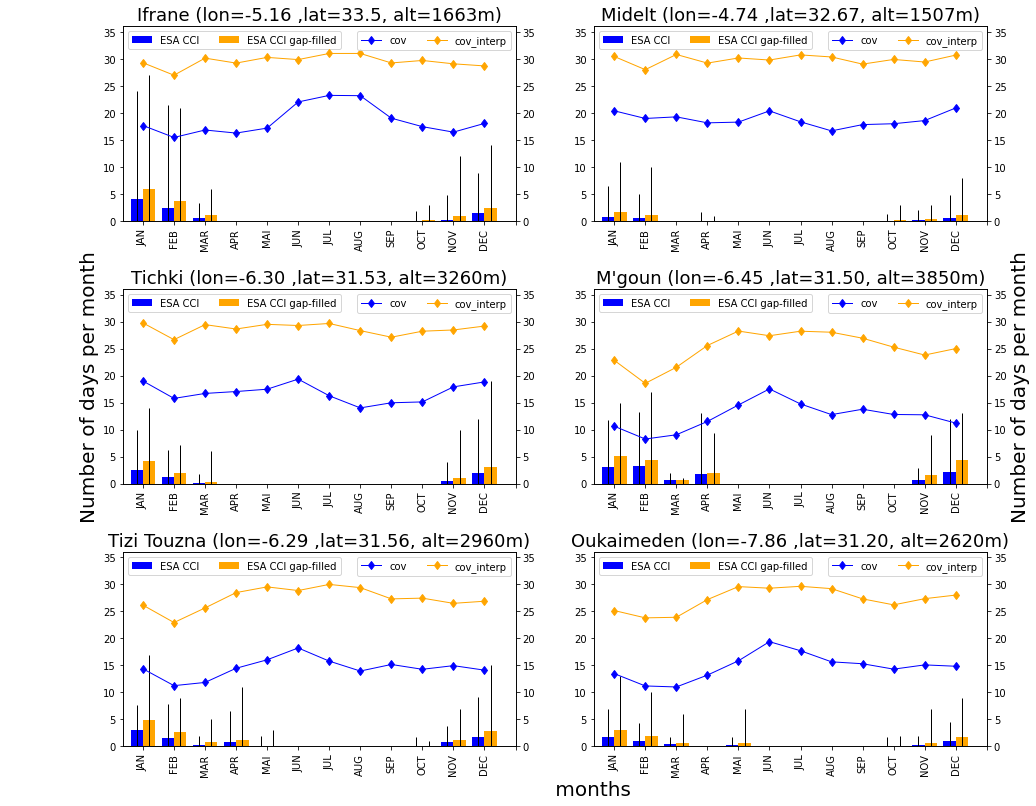

In [69]:
fig, axs=plt.subplots(3,2) 
# We fix the spaces between the subfigures
plt.subplots_adjust(wspace=0.2,hspace=0.35)

# We fix the size of figure
set_size(12,10)     

, female, width=0.4
c1 = 'blue'  
c2 = 'orange'
c3 = 'green'

ax = axs[0][0]
ifr.plot.bar(yerr=[IFR_scfg_ext,IFR_scfg_interp_ext], ax=ax, width=0.8, color=[c1, c2], grid=False, error_kw=dict(ecolor='black',elinewidth=1))
ax.set_xlabel("", fontsize=10) 
ax.legend(labels = ["ESA CCI","ESA CCI gap-filled"], loc='upper left', fontsize = 10, ncol=3)
ax.set_title("Ifrane (lon=-5.16 ,lat=33.5, alt=1663m)", fontsize = 18)
ax.set_ylim(0,36)


ax2 = ax.twinx()

IFR_cov_mean['cov'].plot.line(ax=ax2, color=c1, marker='d', linewidth=1)
IFR_cov_mean['cov_interp'].plot.line(ax=ax2, color=c2, marker='d', linewidth=1)
ax2.legend(labels = ["cov", "cov_interp"], loc='upper right', fontsize = 10, ncol=2)
ax2.set_ylim(0,36)
plt.xticks(ticks=[0,1,2,3,4,5,6,7,8,9,10,11,12], labels=["JAN","FEB","MAR","APR","MAI","JUN","JUL","AUG","SEP","OCT","NOV","DEC",""], fontsize=8)
#=============================== Midelt ===========================================

ax = axs[0][1]
mid.plot.bar(yerr=[MID_scfg_ext,MID_scfg_interp_ext], ax=ax, width=0.8, color=[c1, c2], grid=False, error_kw=dict(ecolor='black',elinewidth=1))
ax.set_xlabel("", fontsize=10) 
ax.legend(labels = ["ESA CCI","ESA CCI gap-filled"], loc='upper left', fontsize = 10, ncol=3)
ax.set_title("Midelt (lon=-4.74 ,lat=32.67, alt=1507m)", fontsize = 18)
ax.set_ylim(0,36)


ax2 = ax.twinx()

MID_cov_mean['cov'].plot.line(ax=ax2, color=c1, marker='d', linewidth=1)
MID_cov_mean['cov_interp'].plot.line(ax=ax2, color=c2, marker='d', linewidth=1)
ax2.legend(labels = ["cov", "cov_interp"], loc='upper right', fontsize = 10, ncol=2)
ax2.set_ylim(0,36)
plt.xticks(ticks=[0,1,2,3,4,5,6,7,8,9,10,11,12], labels=["JAN","FEB","MAR","APR","MAI","JUN","JUL","AUG","SEP","OCT","NOV","DEC",""], fontsize=8)
#=============================== Tichki ===========================================

ax = axs[1][0]
tic.plot.bar(yerr=[TIC_scfg_ext,TIC_scfg_interp_ext], ax=ax, width=0.8, color=[c1, c2], grid=False, error_kw=dict(ecolor='black',elinewidth=1))
ax.set_xlabel("", fontsize=10) 
ax.set_ylabel("Number of days per month", fontsize=20)
ax.legend(labels = ["Number of days per month"], loc='upper right', fontsize = 10, ncol=2)
ax.legend(labels = ["ESA CCI","ESA CCI gap-filled"], loc='upper left', fontsize = 10, ncol=3)
ax.set_title("Tichki (lon=-6.30 ,lat=31.53, alt=3260m)", fontsize = 18)
ax.set_ylim(0,36)

ax2 = ax.twinx()

TIC_cov_mean['cov'].plot.line(ax=ax2, color=c1, marker='d', linewidth=1)
TIC_cov_mean['cov_interp'].plot.line(ax=ax2, color=c2, marker='d', linewidth=1)
ax2.legend(labels = ["cov", "cov_interp"], loc='upper right', fontsize = 10, ncol=2)
ax2.set_ylim(0,36)
plt.xticks(ticks=[0,1,2,3,4,5,6,7,8,9,10,11,12], labels=["JAN","FEB","MAR","APR","MAI","JUN","JUL","AUG","SEP","OCT","NOV","DEC",""], fontsize=8)
#=============================== M'goun ===========================================

ax = axs[1][1]
mgn.plot.bar(yerr=[MGN_scfg_ext,MGN_scfg_interp_ext], ax=ax, width=0.8, color=[c1, c2], grid=False, error_kw=dict(ecolor='black',elinewidth=1))
ax.set_xlabel("", fontsize=10) 
ax.legend(labels = [ "ESA CCI","ESA CCI gap-filled"], loc='upper left', fontsize = 10, ncol=3)
ax.set_title("M'goun (lon=-6.45 ,lat=31.50, alt=3850m)", fontsize = 18)
ax.set_ylim(0,36)


ax2 = ax.twinx()

MGN_cov_mean['cov'].plot.line(ax=ax2, color=c1, marker='d', linewidth=1)
MGN_cov_mean['cov_interp'].plot.line(ax=ax2, color=c2, marker='d', linewidth=1)
ax2.set_ylabel("Number of days per month", fontsize=20)
ax2.legend(labels = ["cov", "cov_interp"], loc='upper right', fontsize = 10, ncol=2)
ax2.set_ylim(0,36)
plt.xticks(ticks=[0,1,2,3,4,5,6,7,8,9,10,11,12], labels=["JAN","FEB","MAR","APR","MAI","JUN","JUL","AUG","SEP","OCT","NOV","DEC",""], fontsize=8)
#=============================== Tizi Touzna ===========================================

ax = axs[2][0]
tiz.plot.bar(yerr=[TIZ_scfg_ext,TIZ_scfg_interp_ext], ax=ax, width=0.8, color=[c1, c2], grid=False, error_kw=dict(ecolor='black',elinewidth=1))
ax.set_xlabel("                                                                                      months", fontsize=20) 
ax.legend(labels = [ "ESA CCI","ESA CCI gap-filled"], loc='upper left', fontsize = 10, ncol=3)
ax.set_title("Tizi Touzna (lon=-6.29 ,lat=31.56, alt=2960m)", fontsize = 18)
ax.set_ylim(0,36)


ax2 = ax.twinx()

TIZ_cov_mean['cov'].plot.line(ax=ax2, color=c1, marker='d', linewidth=1)
TIZ_cov_mean['cov_interp'].plot.line(ax=ax2, color=c2, marker='d', linewidth=1)
ax2.legend(labels = ["cov", "cov_interp"], loc='upper right', fontsize = 10, ncol=2)
ax2.set_ylim(0,36)
plt.xticks(ticks=[0,1,2,3,4,5,6,7,8,9,10,11,12], labels=["JAN","FEB","MAR","APR","MAI","JUN","JUL","AUG","SEP","OCT","NOV","DEC",""], fontsize=8)
#=============================== Oukaimeden ===========================================

ax = axs[2][1]
ouk.plot.bar(yerr=[OUK_scfg_ext,OUK_scfg_interp_ext], ax=ax, width=0.8, color=[c1, c2], grid=False, error_kw=dict(ecolor='black',elinewidth=1))
ax.legend(labels = [ "ESA CCI","ESA CCI gap-filled"], loc='upper left', fontsize = 10, ncol=3)
ax.set_xlabel("", fontsize=10)
ax.set_title("Oukaimeden (lon=-7.86 ,lat=31.20, alt=2620m)", fontsize = 18)
ax.set_ylim(0,36)


ax2 = ax.twinx()

OUK_cov_mean['cov'].plot.line(ax=ax2, color=c1, marker='d', linewidth=1)
OUK_cov_mean['cov_interp'].plot.line(ax=ax2, color=c2, marker='d', linewidth=1)
ax2.legend(labels = ["cov", "cov_interp"], loc='upper right', fontsize = 10, ncol=2)
ax2.set_ylim(0,36)
plt.xticks(ticks=[0,1,2,3,4,5,6,7,8,9,10,11,12], labels=["JAN","FEB","MAR","APR","MAI","JUN","JUL","AUG","SEP","OCT","NOV","DEC",""], fontsize=8)

plt.savefig('comparison_esa_cci_gf_nongf_month_disp.png')  

<h1 style="font-size:2rem; color:green;"> Comparison of trends  </h1>

<div class="alert alert-block alert-success"; background-color:red> We calculate the trends in the four months of the wet period using the non-parametric Mann-Kendall test  </div> 

<h1 style="font-size:1.5rem; color:green;"> Ifrane </h1>

In [70]:
Snow_esa = IFR_scfg['scfg'].where(IFR_scfg['scfg'] > 0).groupby(by=[IFR_scfg.index.month,IFR_scfg.index.year]).count() 
Sum_esa = IFR_scfg['scfg'].where(IFR_scfg['scfg'] >= 0).groupby(by=[IFR_scfg.index.month,IFR_scfg.index.year]).count() 
Nan_esa = IFR_scfg['scfg'].where(IFR_scfg['scfg'] < 0).groupby(by=[IFR_scfg.index.month,IFR_scfg.index.year]).count()

Snow_esa_gf = IFR_scfg_interp['scfg_interp'].where(IFR_scfg_interp['scfg_interp'] > 0).groupby(by=[IFR_scfg_interp.index.month,IFR_scfg_interp.index.year]).count() 
Sum_esa_gf = IFR_scfg_interp['scfg_interp'].where(IFR_scfg_interp['scfg_interp'] >= 0).groupby(by=[IFR_scfg_interp.index.month,IFR_scfg_interp.index.year]).count() 
Nan_esa_gf = IFR_scfg_interp['scfg_interp'].where(IFR_scfg_interp['scfg_interp'] < 0).groupby(by=[IFR_scfg_interp.index.month,IFR_scfg_interp.index.year]).count()

years = [y for y in range(1982,2019)]
for mon in range(1,13):
    for year in years:
        try: 
            if Nan_esa[mon][year]>15:
                Nan_esa[mon][year] = -9999
                Snow_esa[mon][year] = -9999
                
        except KeyError:
            continue            
            
years = [y for y in range(1982,2019)]
for mon in range(1,13):
    for year in years:
        try: 
            if Nan_esa_gf[mon][year]>15:
                Nan_esa_gf[mon][year] = -9999
                Snow_esa_gf[mon][year] = -9999
                
        except KeyError:
            continue
             
Nan_esa = Nan_esa.replace(-9999, np.nan)
Snow_esa = Snow_esa.replace(-9999, np.nan)

Nan_esa_gf = Nan_esa_gf.replace(-9999, np.nan)
Snow_esa_gf = Snow_esa_gf.replace(-9999, np.nan)
       
IFR_scfg_Sdays =   Snow_esa + Snow_esa*Nan_esa/Sum_esa            
IFR_scfg_interp_Sdays =   Snow_esa_gf  + Snow_esa_gf*Nan_esa_gf/Sum_esa_gf      

<h1 style="font-size:1.5rem; color:green;"> Midelt </h1>

In [71]:
Snow_esa = MID_scfg['scfg'].where(MID_scfg['scfg'] > 0).groupby(by=[MID_scfg.index.month,MID_scfg.index.year]).count() 
Sum_esa = MID_scfg['scfg'].where(MID_scfg['scfg'] >= 0).groupby(by=[MID_scfg.index.month,MID_scfg.index.year]).count() 
Nan_esa = MID_scfg['scfg'].where(MID_scfg['scfg'] < 0).groupby(by=[MID_scfg.index.month,MID_scfg.index.year]).count()

Snow_esa_gf = MID_scfg_interp['scfg_interp'].where(MID_scfg_interp['scfg_interp'] > 0).groupby(by=[MID_scfg_interp.index.month,MID_scfg_interp.index.year]).count() 
Sum_esa_gf = MID_scfg_interp['scfg_interp'].where(MID_scfg_interp['scfg_interp'] >= 0).groupby(by=[MID_scfg_interp.index.month,MID_scfg_interp.index.year]).count() 
Nan_esa_gf = MID_scfg_interp['scfg_interp'].where(MID_scfg_interp['scfg_interp'] < 0).groupby(by=[MID_scfg_interp.index.month,MID_scfg_interp.index.year]).count()

years = [y for y in range(1982,2019)]
for mon in range(1,13):
    for year in years:
        try: 
            if Nan_esa[mon][year]>15:
                Nan_esa[mon][year] = -9999
                Snow_esa[mon][year] = -9999               
        except KeyError:
            continue 
            
years = [y for y in range(1982,2019)]
for mon in range(1,13):
    for year in years:
        try: 
            if Nan_esa_gf[mon][year]>15:
                Nan_esa_gf[mon][year] = -9999
                Snow_esa_gf[mon][year] = -9999
                
        except KeyError:
            continue
            
Nan_esa = Nan_esa.replace(-9999, np.nan)
Snow_esa = Snow_esa.replace(-9999, np.nan)

Nan_esa_gf = Nan_esa_gf.replace(-9999, np.nan)
Snow_esa_gf = Snow_esa_gf.replace(-9999, np.nan)
       
MID_scfg_Sdays =   Snow_esa + Snow_esa*Nan_esa/Sum_esa            
MID_scfg_interp_Sdays =   Snow_esa_gf  + Snow_esa_gf*Nan_esa_gf/Sum_esa_gf      

<h1 style="font-size:1.5rem; color:green;"> Tichki </h1>

In [72]:
Snow_esa = TIC_scfg['scfg'].where(TIC_scfg['scfg'] > 0).groupby(by=[TIC_scfg.index.month,TIC_scfg.index.year]).count() 
Sum_esa = TIC_scfg['scfg'].where(TIC_scfg['scfg'] >= 0).groupby(by=[TIC_scfg.index.month,TIC_scfg.index.year]).count() 
Nan_esa = TIC_scfg['scfg'].where(TIC_scfg['scfg'] < 0).groupby(by=[TIC_scfg.index.month,TIC_scfg.index.year]).count()

Snow_esa_gf = TIC_scfg_interp['scfg_interp'].where(TIC_scfg_interp['scfg_interp'] > 0).groupby(by=[TIC_scfg_interp.index.month,TIC_scfg_interp.index.year]).count() 
Sum_esa_gf = TIC_scfg_interp['scfg_interp'].where(TIC_scfg_interp['scfg_interp'] >= 0).groupby(by=[TIC_scfg_interp.index.month,TIC_scfg_interp.index.year]).count() 
Nan_esa_gf = TIC_scfg_interp['scfg_interp'].where(TIC_scfg_interp['scfg_interp'] < 0).groupby(by=[TIC_scfg_interp.index.month,TIC_scfg_interp.index.year]).count()

years = [y for y in range(1982,2019)]
for mon in range(1,13):
    for year in years:
        try: 
            if Nan_esa[mon][year]>15:
                Nan_esa[mon][year] = -9999
                Snow_esa[mon][year] = -9999
                
        except KeyError:
            continue 
            
years = [y for y in range(1982,2019)]
for mon in range(1,13):
    for year in years:
        try: 
            if Nan_esa_gf[mon][year]>15:
                Nan_esa_gf[mon][year] = -9999
                Snow_esa_gf[mon][year] = -9999
                
        except KeyError:
            continue
            
Nan_esa = Nan_esa.replace(-9999, np.nan)
Snow_esa = Snow_esa.replace(-9999, np.nan)

Nan_esa_gf = Nan_esa_gf.replace(-9999, np.nan)
Snow_esa_gf = Snow_esa_gf.replace(-9999, np.nan)
       
TIC_scfg_Sdays =   Snow_esa + Snow_esa*Nan_esa/Sum_esa            
TIC_scfg_interp_Sdays =   Snow_esa_gf  + Snow_esa_gf*Nan_esa_gf/Sum_esa_gf      

<h1 style="font-size:1.5rem; color:green;"> M'goun </h1>

In [73]:
Snow_esa = MGN_scfg['scfg'].where(MGN_scfg['scfg'] > 0).groupby(by=[MGN_scfg.index.month,MGN_scfg.index.year]).count() 
Sum_esa = MGN_scfg['scfg'].where(MGN_scfg['scfg'] >= 0).groupby(by=[MGN_scfg.index.month,MGN_scfg.index.year]).count() 
Nan_esa = MGN_scfg['scfg'].where(MGN_scfg['scfg'] < 0).groupby(by=[MGN_scfg.index.month,MGN_scfg.index.year]).count()

Snow_esa_gf = MGN_scfg_interp['scfg_interp'].where(MGN_scfg_interp['scfg_interp'] > 0).groupby(by=[MGN_scfg_interp.index.month,MGN_scfg_interp.index.year]).count() 
Sum_esa_gf = MGN_scfg_interp['scfg_interp'].where(MGN_scfg_interp['scfg_interp'] >= 0).groupby(by=[MGN_scfg_interp.index.month,MGN_scfg_interp.index.year]).count() 
Nan_esa_gf = MGN_scfg_interp['scfg_interp'].where(MGN_scfg_interp['scfg_interp'] < 0).groupby(by=[MGN_scfg_interp.index.month,MGN_scfg_interp.index.year]).count()

years = [y for y in range(1982,2019)]
for mon in range(1,13):
    for year in years:
        try: 
            if Nan_esa[mon][year]>15:
                Nan_esa[mon][year] = -9999
                Snow_esa[mon][year] = -9999
                
        except KeyError:
            continue 
            
years = [y for y in range(1982,2019)]
for mon in range(1,13):
    for year in years:
        try: 
            if Nan_esa_gf[mon][year]>15:
                Nan_esa_gf[mon][year] = -9999
                Snow_esa_gf[mon][year] = -9999
                
        except KeyError:
            continue
            
            
Nan_esa = Nan_esa.replace(-9999, np.nan)
Snow_esa = Snow_esa.replace(-9999, np.nan)

Nan_esa_gf = Nan_esa_gf.replace(-9999, np.nan)
Snow_esa_gf = Snow_esa_gf.replace(-9999, np.nan)
       
MGN_scfg_Sdays =   Snow_esa + Snow_esa*Nan_esa/Sum_esa            
MGN_scfg_interp_Sdays =   Snow_esa_gf  + Snow_esa_gf*Nan_esa_gf/Sum_esa_gf      

<h1 style="font-size:1.5rem; color:green;"> Tizi Touzna </h1>

In [74]:
Snow_esa = TIZ_scfg['scfg'].where(TIZ_scfg['scfg'] > 0).groupby(by=[TIZ_scfg.index.month,TIZ_scfg.index.year]).count() 
Sum_esa = TIZ_scfg['scfg'].where(TIZ_scfg['scfg'] >= 0).groupby(by=[TIZ_scfg.index.month,TIZ_scfg.index.year]).count() 
Nan_esa = TIZ_scfg['scfg'].where(TIZ_scfg['scfg'] < 0).groupby(by=[TIZ_scfg.index.month,TIZ_scfg.index.year]).count()

Snow_esa_gf = TIZ_scfg_interp['scfg_interp'].where(TIZ_scfg_interp['scfg_interp'] > 0).groupby(by=[TIZ_scfg_interp.index.month,TIZ_scfg_interp.index.year]).count() 
Sum_esa_gf = TIZ_scfg_interp['scfg_interp'].where(TIZ_scfg_interp['scfg_interp'] >= 0).groupby(by=[TIZ_scfg_interp.index.month,TIZ_scfg_interp.index.year]).count() 
Nan_esa_gf = TIZ_scfg_interp['scfg_interp'].where(TIZ_scfg_interp['scfg_interp'] < 0).groupby(by=[TIZ_scfg_interp.index.month,TIZ_scfg_interp.index.year]).count()

years = [y for y in range(1982,2019)]
for mon in range(1,13):
    for year in years:
        try: 
            if Nan_esa[mon][year]>15:
                Nan_esa[mon][year] = -9999
                Snow_esa[mon][year] = -9999
              
        except KeyError:
            continue 
            
years = [y for y in range(1982,2019)]
for mon in range(1,13):
    for year in years:
        try: 
            if Nan_esa_gf[mon][year]>15:
                Nan_esa_gf[mon][year] = -9999
                Snow_esa_gf[mon][year] = -9999
                
        except KeyError:
            continue
            
Nan_esa = Nan_esa.replace(-9999, np.nan)
Snow_esa = Snow_esa.replace(-9999, np.nan)

Nan_esa_gf = Nan_esa_gf.replace(-9999, np.nan)
Snow_esa_gf = Snow_esa_gf.replace(-9999, np.nan)
       
TIZ_scfg_Sdays =   Snow_esa + Snow_esa*Nan_esa/Sum_esa            
TIZ_scfg_interp_Sdays =   Snow_esa_gf  + Snow_esa_gf*Nan_esa_gf/Sum_esa_gf      

<h1 style="font-size:1.5rem; color:green;"> Oukaimeden </h1>

In [75]:
Snow_esa = OUK_scfg['scfg'].where(OUK_scfg['scfg'] > 0).groupby(by=[OUK_scfg.index.month,OUK_scfg.index.year]).count() 
Sum_esa = OUK_scfg['scfg'].where(OUK_scfg['scfg'] >= 0).groupby(by=[OUK_scfg.index.month,OUK_scfg.index.year]).count() 
Nan_esa = OUK_scfg['scfg'].where(OUK_scfg['scfg'] < 0).groupby(by=[OUK_scfg.index.month,OUK_scfg.index.year]).count()

Snow_esa_gf = OUK_scfg_interp['scfg_interp'].where(OUK_scfg_interp['scfg_interp'] > 0).groupby(by=[OUK_scfg_interp.index.month,OUK_scfg_interp.index.year]).count() 
Sum_esa_gf = OUK_scfg_interp['scfg_interp'].where(OUK_scfg_interp['scfg_interp'] >= 0).groupby(by=[OUK_scfg_interp.index.month,OUK_scfg_interp.index.year]).count() 
Nan_esa_gf = OUK_scfg_interp['scfg_interp'].where(OUK_scfg_interp['scfg_interp'] < 0).groupby(by=[OUK_scfg_interp.index.month,OUK_scfg_interp.index.year]).count()

years = [y for y in range(1982,2019)]
for mon in range(1,13):
    for year in years:
        try: 
            if Nan_esa[mon][year]>15:
                Nan_esa[mon][year] = -9999
                Snow_esa[mon][year] = -9999
                
        except KeyError:
            continue 
            
years = [y for y in range(1982,2019)]
for mon in range(1,13):
    for year in years:
        try: 
            if Nan_esa_gf[mon][year]>15:
                Nan_esa_gf[mon][year] = -9999
                Snow_esa_gf[mon][year] = -9999
                
        except KeyError:
            continue    
            
Nan_esa = Nan_esa.replace(-9999, np.nan)
Snow_esa = Snow_esa.replace(-9999, np.nan)

Nan_esa_gf = Nan_esa_gf.replace(-9999, np.nan)
Snow_esa_gf = Snow_esa_gf.replace(-9999, np.nan)
       
OUK_scfg_Sdays =   Snow_esa + Snow_esa*Nan_esa/Sum_esa            
OUK_scfg_interp_Sdays =   Snow_esa_gf  + Snow_esa_gf*Nan_esa_gf/Sum_esa_gf      

<div class="alert alert-block alert-success"; background-color:red> Now we visualize the curves of the monthly values of number of days with snow over land with the trend curves and the values of trend parameters  </div> 

<h1 style="font-size:1.5rem; color:green;"> Ifrane </h1>

Text(0.5, 0, 'years')

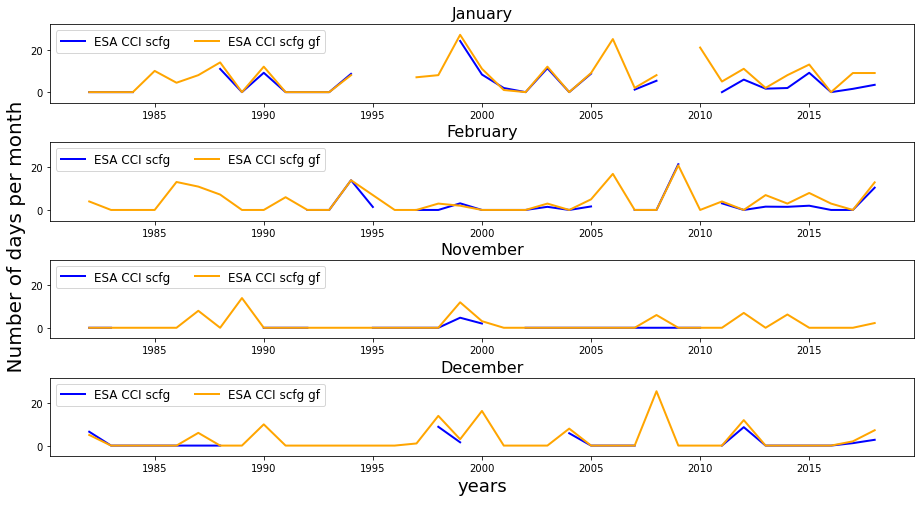

In [77]:
labels_months = ["January","February", "November", "December"]
labels_legend = ['ESA CCI scfg', 'ESA CCI scfg gf']

fig, axs=plt.subplots(4,1) 

# We fix the spaces between the subfigures
plt.subplots_adjust(wspace=1,hspace=0.5)

# We fix the size of figure
set_size(12,6)
c1 = 'blue'
c2 = 'orange'
mons=[1,2,11,12]
for i in range(4):
    IFR_scfg_Sdays[mons[i]].plot(ax=axs[i], color=c1, linewidth=2)
    IFR_scfg_interp_Sdays[mons[i]].plot(ax=axs[i], color=c2, linewidth=2)
    axs[i].set_title(labels_months[i], fontsize=16)
    axs[i].set_xlabel("", fontsize=18)
    axs[i].legend(labels = labels_legend, loc='upper left', ncol=2, fontsize=12) 
    axs[i].set_ylim(-5,32)

axs[2].set_ylabel("                    Number of days per month", fontsize=20)
axs[3].set_xlabel("years", fontsize=18)

plt.savefig('IFR_mon_value_timeserie.png') 

<h1 style="font-size:1.5rem; color:green;"> Midelt </h1>

Text(0.5, 0, 'years')

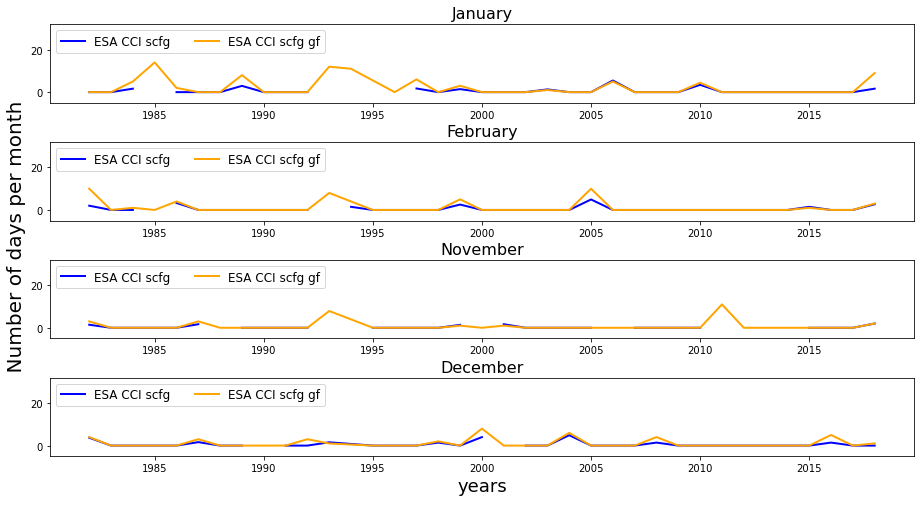

In [78]:
labels_months = ["January","February", "November", "December"]
labels_legend = ['ESA CCI scfg', 'ESA CCI scfg gf']

fig, axs=plt.subplots(4,1) 

# We fix the spaces between the subfigures
plt.subplots_adjust(wspace=1,hspace=0.5)

# We fix the size of figure
set_size(12,6)
c1 = 'blue'
c2 = 'orange'
mons=[1,2,11,12]
for i in range(4):
    MID_scfg_Sdays[mons[i]].plot(ax=axs[i], color=c1, linewidth=2)
    MID_scfg_interp_Sdays[mons[i]].plot(ax=axs[i], color=c2, linewidth=2)
    axs[i].set_title(labels_months[i], fontsize=16)
    axs[i].set_xlabel("", fontsize=18)
    axs[i].legend(labels = labels_legend, loc='upper left', ncol=2, fontsize=12) 
    axs[i].set_ylim(-5,32)

axs[2].set_ylabel("                    Number of days per month", fontsize=20)
axs[3].set_xlabel("years", fontsize=18)
plt.savefig('MID_mon_value_timeserie.png') 

<h1 style="font-size:1.5rem; color:green;"> Tichki </h1>

Text(0.5, 0, 'years')

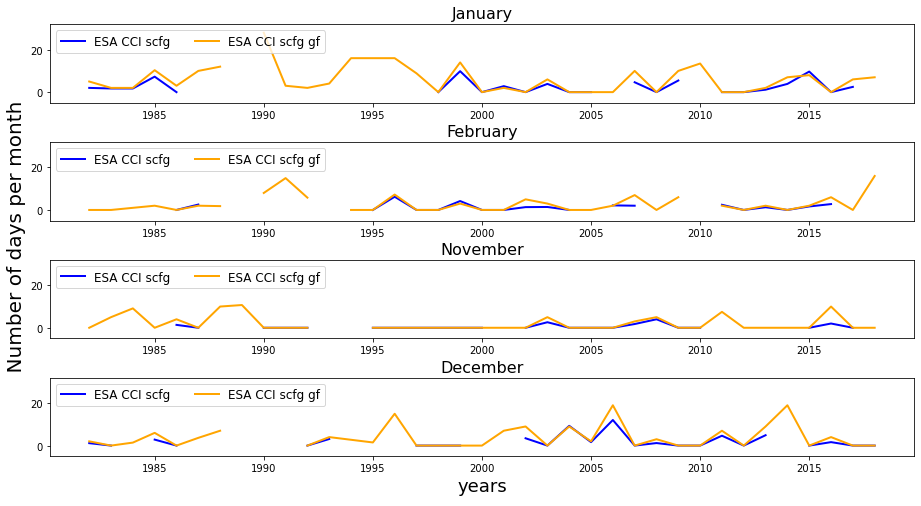

In [79]:
labels_months = ["January","February", "November", "December"]
labels_legend = ['ESA CCI scfg', 'ESA CCI scfg gf']

fig, axs=plt.subplots(4,1) 

# We fix the spaces between the subfigures
plt.subplots_adjust(wspace=1,hspace=0.5)

# We fix the size of figure
set_size(12,6)
c1 = 'blue'
c2 = 'orange'
mons=[1,2,11,12]
for i in range(4):
    TIC_scfg_Sdays[mons[i]].plot(ax=axs[i], color=c1, linewidth=2)
    TIC_scfg_interp_Sdays[mons[i]].plot(ax=axs[i], color=c2, linewidth=2)
    axs[i].set_title(labels_months[i], fontsize=16)
    axs[i].set_xlabel("", fontsize=18)
    axs[i].legend(labels = labels_legend, loc='upper left', ncol=2, fontsize=12) 
    axs[i].set_ylim(-5,32)

axs[2].set_ylabel("                    Number of days per month", fontsize=20)
axs[3].set_xlabel("years", fontsize=18)
plt.savefig('TIC_mon_value_timeserie.png') 

<h1 style="font-size:1.5rem; color:green;"> M'goun </h1>

Text(0.5, 0, 'years')

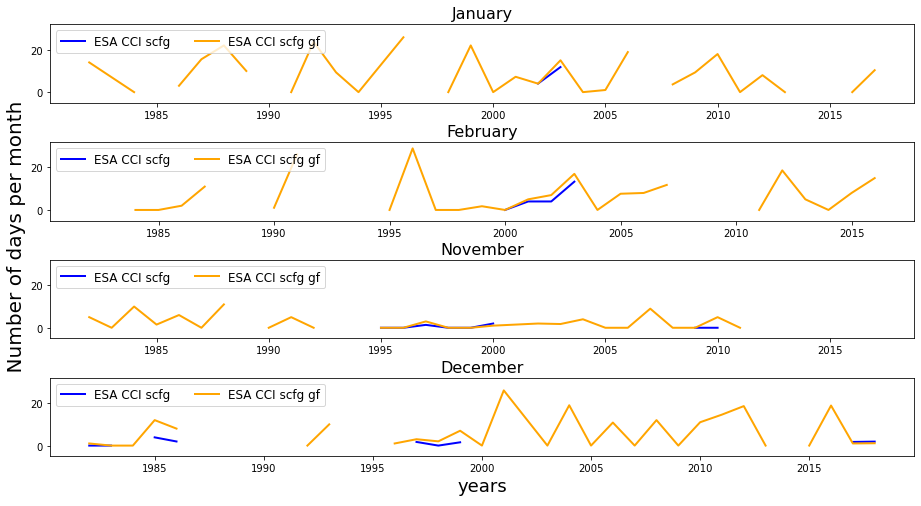

In [81]:
labels_months = ["January","February", "November", "December"]
labels_legend = ['ESA CCI scfg', 'ESA CCI scfg gf']

fig, axs=plt.subplots(4,1) 

# We fix the spaces between the subfigures
plt.subplots_adjust(wspace=1,hspace=0.5)

# We fix the size of figure
set_size(12,6)
c1 = 'blue'
c2 = 'orange'
mons=[1,2,11,12]
for i in range(4):
    MGN_scfg_Sdays[mons[i]].plot(ax=axs[i], color=c1, linewidth=2)
    MGN_scfg_interp_Sdays[mons[i]].plot(ax=axs[i], color=c2, linewidth=2)
    axs[i].set_title(labels_months[i], fontsize=16)
    axs[i].set_xlabel("", fontsize=18)
    axs[i].legend(labels = labels_legend, loc='upper left', ncol=2, fontsize=12) 
    axs[i].set_ylim(-5,32)

axs[2].set_ylabel("                    Number of days per month", fontsize=20)
axs[3].set_xlabel("years", fontsize=18)
plt.savefig('MGN_mon_value_timeserie.png') 

<h1 style="font-size:1.5rem; color:green;"> Tizi Touzna </h1>

Text(0.5, 0, 'years')

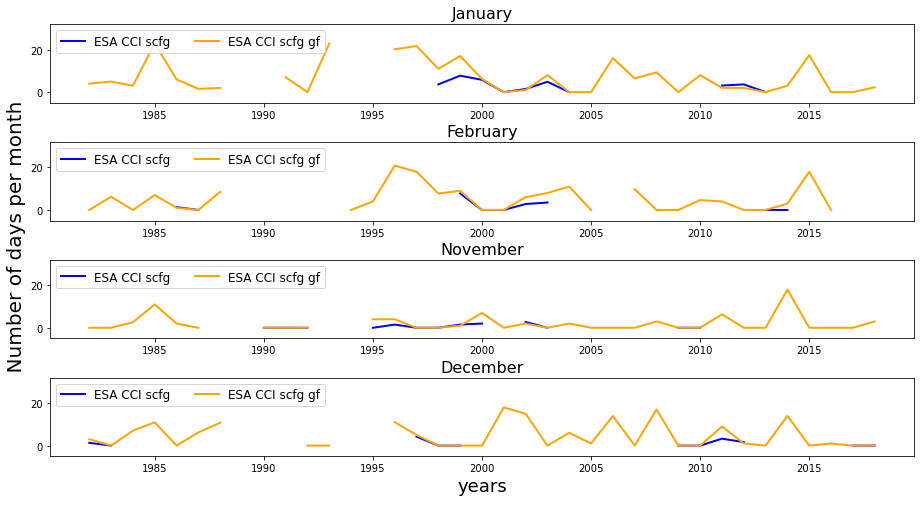

In [83]:
labels_months = ["January","February", "November", "December"]
labels_legend = ['ESA CCI scfg', 'ESA CCI scfg gf']

fig, axs=plt.subplots(4,1) 

# We fix the spaces between the subfigures
plt.subplots_adjust(wspace=1,hspace=0.5)

# We fix the size of figure
set_size(12,6)
c1 = 'blue'
c2 = 'orange'
mons=[1,2,11,12]
for i in range(4):
    TIZ_scfg_Sdays[mons[i]].plot(ax=axs[i], color=c1, linewidth=2)
    TIZ_scfg_interp_Sdays[mons[i]].plot(ax=axs[i], color=c2, linewidth=2)
    axs[i].set_title(labels_months[i], fontsize=16)
    axs[i].set_xlabel("", fontsize=18)
    axs[i].legend(labels = labels_legend, loc='upper left', ncol=2, fontsize=12) 
    axs[i].set_ylim(-5,32)

axs[2].set_ylabel("                    Number of days per month", fontsize=20)
axs[3].set_xlabel("years", fontsize=18)

plt.savefig('TIZ_mon_value_timeserie.png')  

<h1 style="font-size:1.5rem; color:green;"> Oukaimeden </h1>

Text(0.5, 0, 'years')

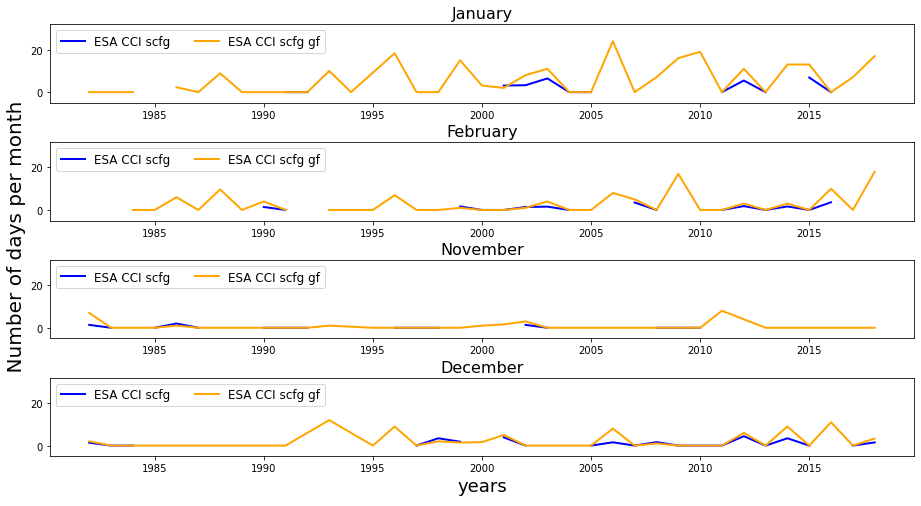

In [84]:
labels_months = ["January","February", "November", "December"]
labels_legend = ['ESA CCI scfg', 'ESA CCI scfg gf']

fig, axs=plt.subplots(4,1) 

# We fix the spaces between the subfigures
plt.subplots_adjust(wspace=1,hspace=0.5)

# We fix the size of figure
set_size(12,6)
c1 = 'blue'
c2 = 'orange'
mons=[1,2,11,12]
for i in range(4):
    OUK_scfg_Sdays[mons[i]].plot(ax=axs[i], color=c1, linewidth=2)
    OUK_scfg_interp_Sdays[mons[i]].plot(ax=axs[i], color=c2, linewidth=2)
    axs[i].set_title(labels_months[i], fontsize=16)
    axs[i].set_xlabel("", fontsize=18)
    axs[i].legend(labels = labels_legend, loc='upper left', ncol=2, fontsize=12) 
    axs[i].set_ylim(-5,32)

axs[2].set_ylabel("                    Number of days per month", fontsize=20)
axs[3].set_xlabel("years", fontsize=18)
plt.savefig('OUK_mon_value_timeserie.png')  

<h1 style="font-size:1.5rem; color:green;"> Ifrane </h1>

Text(0, 0.5, '                                                                     Number of days per month')

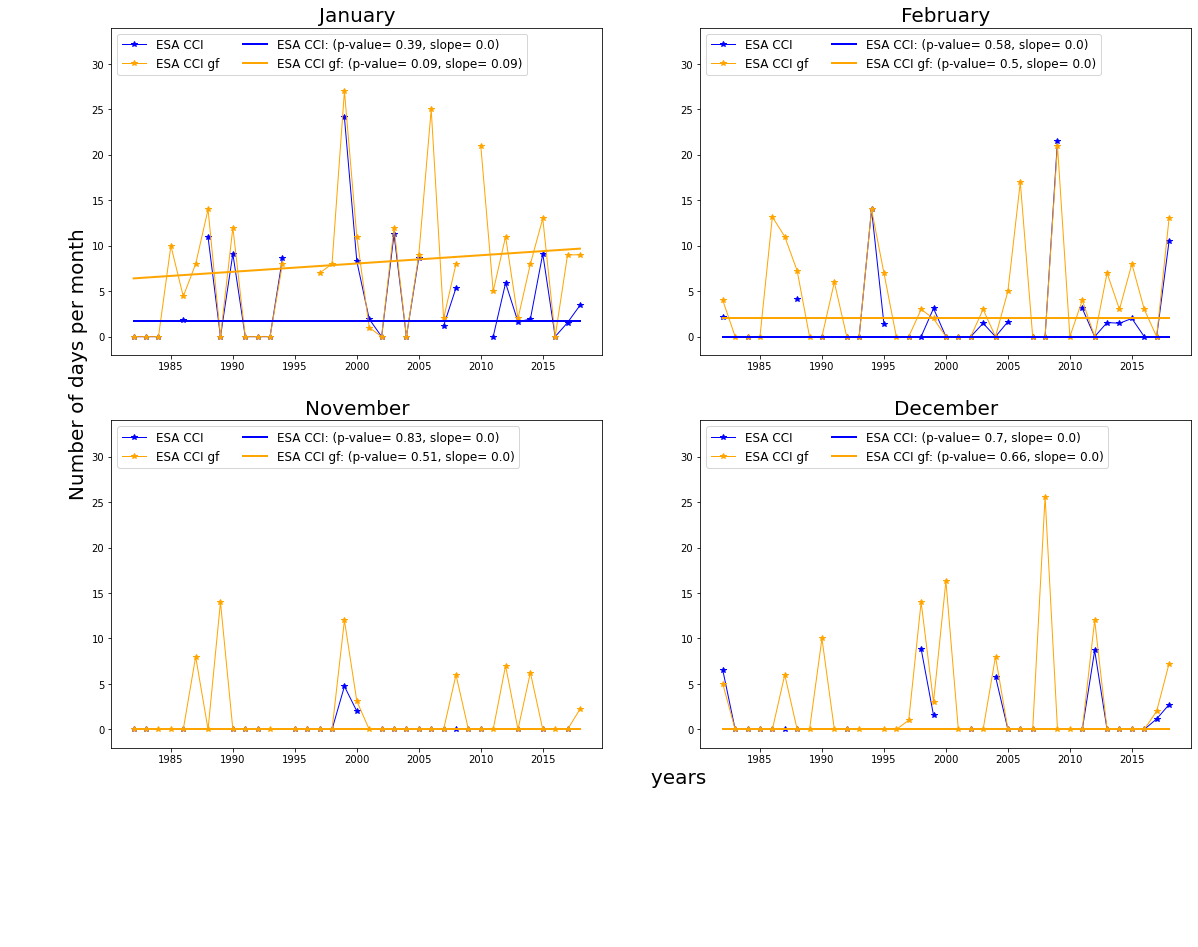

In [90]:
labels_months = ["January", "February", "November", "December"]

fig, axs=plt.subplots(2,2)

# We fix the spaces between the subfigures
plt.subplots_adjust(wspace=0.2,hspace=0.2)

# We fix the size of figure
set_size(15,10)

mons=[1,2,11,12]
years = [int(y) for y in range(1982,2019)]
index = 0
for i in range(2):
    for j in range(2):
        slope = mk.original_test(IFR_scfg_Sdays[mons[index]]).slope
        slope_gf = mk.original_test(IFR_scfg_interp_Sdays[mons[index]]).slope
    
        p = mk.original_test(IFR_scfg_Sdays[mons[index]]).p
        p_gf = mk.original_test(IFR_scfg_interp_Sdays[mons[index]]).p

        interc = mk.original_test(IFR_scfg_Sdays[mons[index]]).intercept
        interc_gf = mk.original_test(IFR_scfg_interp_Sdays[mons[index]]).intercept

        droit = [slope*k+ interc for k in range(37)]
        droit_gf = [slope_gf*k+ interc_gf for k in range(37)]
        
        droit = pd.DataFrame({'year': years, 'N': droit})
        droit = droit.set_index('year')
    
        droit_gf = pd.DataFrame({'year': years, 'N': droit_gf})
        droit_gf = droit_gf.set_index('year')
    
        labels_legend = ["ESA CCI" ,"ESA CCI gf",
                         "ESA CCI: (p-value= "+str(np.around(p,decimals=2))+", slope= "+str(np.around(slope, decimals=2))+")",
                         "ESA CCI gf: (p-value= "+str(np.around(p_gf, decimals=2))+", slope= "+str(np.around(slope_gf, decimals=2))+")"]
    
    
        IFR_scfg_Sdays[mons[index]].plot(ax=axs[i][j], color=c1,  linewidth=1, marker='*')
        IFR_scfg_interp_Sdays[mons[index]].plot(ax=axs[i][j], color=c2, marker='*', linewidth=1)
        
        droit.plot(ax=axs[i][j], ylim=[-2,34], color=c1,  linewidth=2)
        droit_gf.plot(ax=axs[i][j], ylim=[-2,34], color=c2,  linewidth=2)
    
        axs[i][j].set_title(labels_months[index], fontsize=20)
        axs[i][j].set_xlabel("")
        axs[i][j].legend(labels = labels_legend, loc='upper left', ncol=2, fontsize=12)
        axs[i][j].set_ylabel("") 
        axs[i][j].set_ylim(-2,34)
        
        index = index + 1
        
        
axs[1][0].set_xlabel("                                                                                                     years", fontsize=20)
axs[1][0].set_ylabel("                                                                     Number of days per month", fontsize=20)

plt.savefig('IFR_comparison_trend.png')  

<h1 style="font-size:1.5rem; color:green;"> Midelt </h1>

Text(0, 0.5, '                                                                     Number of days per month')

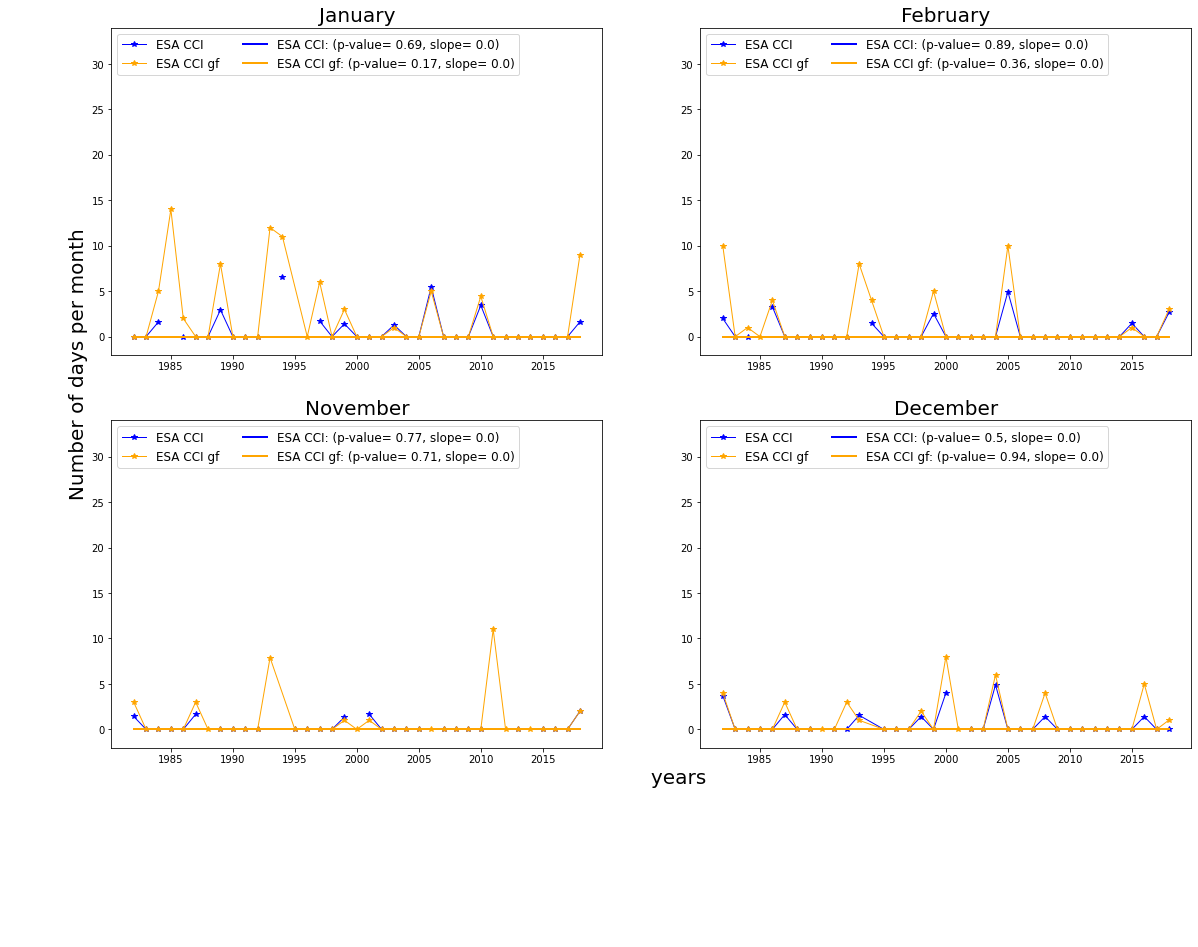

In [91]:
labels_months = ["January", "February", "November", "December"]

fig, axs=plt.subplots(2,2) 

# We fix the spaces between the subfigures
plt.subplots_adjust(wspace=0.2,hspace=0.2)

# We fix the size of figure
set_size(15,10)

mons=[1,2,11,12]
years = [int(y) for y in range(1982,2019)]
index = 0
for i in range(2):
    for j in range(2):
        slope = mk.original_test(MID_scfg_Sdays[mons[index]]).slope
        slope_gf = mk.original_test(MID_scfg_interp_Sdays[mons[index]]).slope
    
        p = mk.original_test(MID_scfg_Sdays[mons[index]]).p
        p_gf = mk.original_test(MID_scfg_interp_Sdays[mons[index]]).p

        interc = mk.original_test(MID_scfg_Sdays[mons[index]]).intercept
        interc_gf = mk.original_test(MID_scfg_interp_Sdays[mons[index]]).intercept

        droit = [slope*k+ interc for k in range(37)]
        droit_gf = [slope_gf*k+ interc_gf for k in range(37)]
        
        droit = pd.DataFrame({'year': years, 'N': droit})
        droit = droit.set_index('year')
    
        droit_gf = pd.DataFrame({'year': years, 'N': droit_gf})
        droit_gf = droit_gf.set_index('year')
    
        labels_legend = ["ESA CCI" ,"ESA CCI gf",
                         "ESA CCI: (p-value= "+str(np.around(p,decimals=2))+", slope= "+str(np.around(slope, decimals=2))+")",
                         "ESA CCI gf: (p-value= "+str(np.around(p_gf, decimals=2))+", slope= "+str(np.around(slope_gf, decimals=2))+")"]
    
    
        MID_scfg_Sdays[mons[index]].plot(ax=axs[i][j], color=c1,  linewidth=1, marker='*')
        MID_scfg_interp_Sdays[mons[index]].plot(ax=axs[i][j], color=c2, marker='*', linewidth=1)
        
        droit.plot(ax=axs[i][j], ylim=[-2,34], color=c1,  linewidth=2)
        droit_gf.plot(ax=axs[i][j], ylim=[-2,34], color=c2,  linewidth=2)
    
        axs[i][j].set_title(labels_months[index], fontsize=20)
        axs[i][j].set_xlabel("")
        axs[i][j].legend(labels = labels_legend, loc='upper left', ncol=2, fontsize=12)
        axs[i][j].set_ylabel("") 
        axs[i][j].set_ylim(-2,34)
        
        index = index + 1
        
axs[1][0].set_xlabel("                                                                                                     years", fontsize=20)
axs[1][0].set_ylabel("                                                                     Number of days per month", fontsize=20)
        
plt.savefig('MID_comparison_trend.png')  

<h1 style="font-size:1.5rem; color:green;"> Tichki </h1>

Text(0, 0.5, '                                                                     Number of days per month')

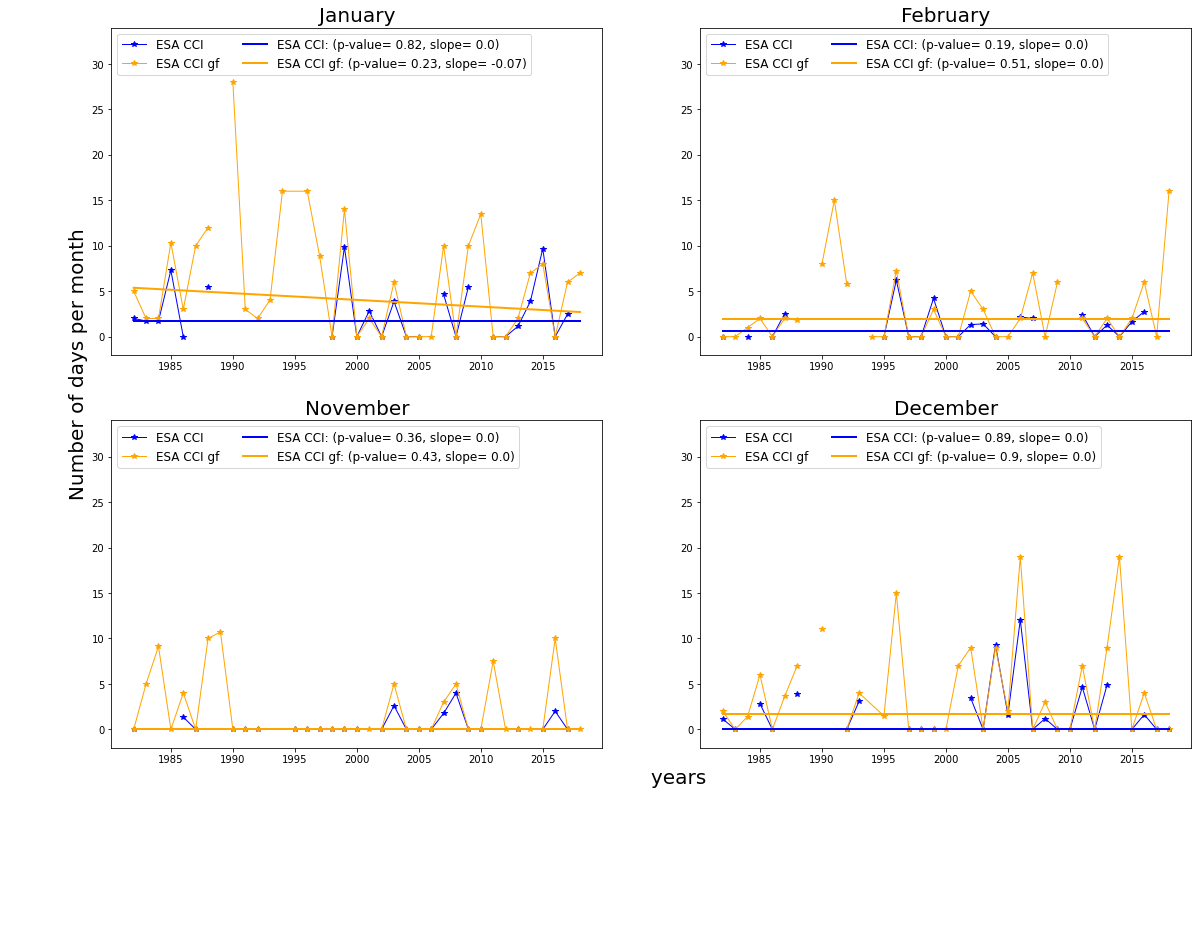

In [92]:
labels_months = ["January", "February", "November", "December"]

fig, axs=plt.subplots(2,2) 

# We fix the spaces between the subfigures
plt.subplots_adjust(wspace=0.2,hspace=0.2)

# We fix the size of figure
set_size(15,10)

mons=[1,2,11,12]
years = [int(y) for y in range(1982,2019)]
index = 0
for i in range(2):
    for j in range(2):
        slope = mk.original_test(TIC_scfg_Sdays[mons[index]]).slope
        slope_gf = mk.original_test(TIC_scfg_interp_Sdays[mons[index]]).slope
    
        p = mk.original_test(TIC_scfg_Sdays[mons[index]]).p
        p_gf = mk.original_test(TIC_scfg_interp_Sdays[mons[index]]).p

        interc = mk.original_test(TIC_scfg_Sdays[mons[index]]).intercept
        interc_gf = mk.original_test(TIC_scfg_interp_Sdays[mons[index]]).intercept

        droit = [slope*k+ interc for k in range(37)]
        droit_gf = [slope_gf*k+ interc_gf for k in range(37)]
        
        droit = pd.DataFrame({'year': years, 'N': droit})
        droit = droit.set_index('year')
    
        droit_gf = pd.DataFrame({'year': years, 'N': droit_gf})
        droit_gf = droit_gf.set_index('year')
    
        labels_legend = ["ESA CCI" ,"ESA CCI gf",
                         "ESA CCI: (p-value= "+str(np.around(p,decimals=2))+", slope= "+str(np.around(slope, decimals=2))+")",
                         "ESA CCI gf: (p-value= "+str(np.around(p_gf, decimals=2))+", slope= "+str(np.around(slope_gf, decimals=2))+")"]
    
    
        TIC_scfg_Sdays[mons[index]].plot(ax=axs[i][j], color=c1,  linewidth=1, marker='*')
        TIC_scfg_interp_Sdays[mons[index]].plot(ax=axs[i][j], color=c2, marker='*', linewidth=1)
        
        droit.plot(ax=axs[i][j], ylim=[-2,34], color=c1,  linewidth=2)
        droit_gf.plot(ax=axs[i][j], ylim=[-2,34], color=c2,  linewidth=2)
    
        axs[i][j].set_title(labels_months[index], fontsize=20)
        axs[i][j].set_xlabel("")
        axs[i][j].legend(labels = labels_legend, loc='upper left', ncol=2, fontsize=12)
        axs[i][j].set_ylabel("") 
        axs[i][j].set_ylim(-2,34)
        
        index = index + 1

axs[1][0].set_xlabel("                                                                                                     years", fontsize=20)
axs[1][0].set_ylabel("                                                                     Number of days per month", fontsize=20)

plt.savefig('TIC_comparison_trend.png')  

<h1 style="font-size:1.5rem; color:green;"> M'goun </h1>

Text(0, 0.5, '                                                                     Number of days per month')

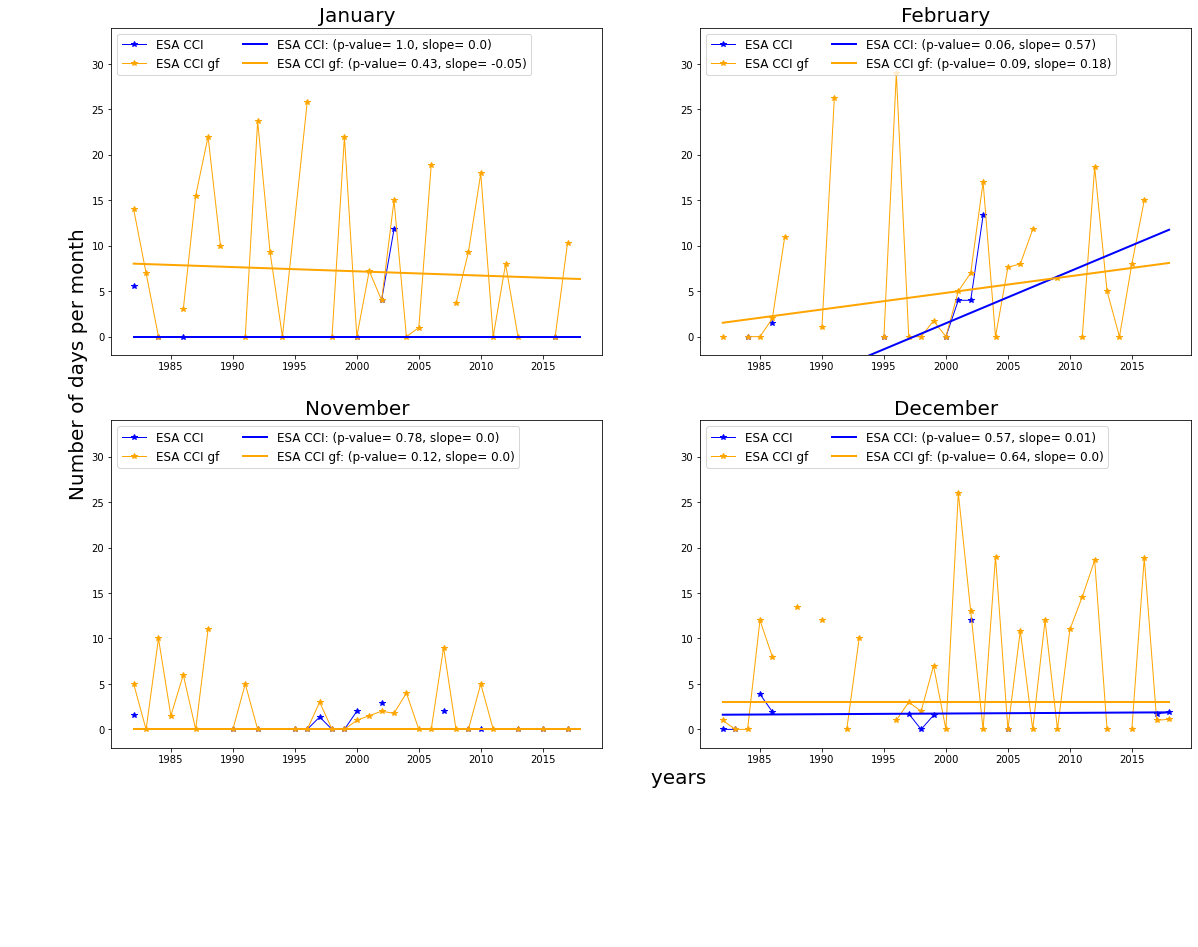

In [93]:
labels_months = ["January", "February", "November", "December"]

fig, axs=plt.subplots(2,2) 

# We fix the spaces between the subfigures
plt.subplots_adjust(wspace=0.2,hspace=0.2)

# We fix the size of figure
set_size(15,10)

mons=[1,2,11,12]
years = [int(y) for y in range(1982,2019)]
index = 0
for i in range(2):
    for j in range(2):
        slope = mk.original_test(MGN_scfg_Sdays[mons[index]]).slope
        slope_gf = mk.original_test(MGN_scfg_interp_Sdays[mons[index]]).slope
    
        p = mk.original_test(MGN_scfg_Sdays[mons[index]]).p
        p_gf = mk.original_test(MGN_scfg_interp_Sdays[mons[index]]).p

        interc = mk.original_test(MGN_scfg_Sdays[mons[index]]).intercept
        interc_gf = mk.original_test(MGN_scfg_interp_Sdays[mons[index]]).intercept

        droit = [slope*k+ interc for k in range(37)]
        droit_gf = [slope_gf*k+ interc_gf for k in range(37)]
        
        droit = pd.DataFrame({'year': years, 'N': droit})
        droit = droit.set_index('year')
    
        droit_gf = pd.DataFrame({'year': years, 'N': droit_gf})
        droit_gf = droit_gf.set_index('year')
    
        labels_legend = ["ESA CCI" ,"ESA CCI gf",
                         "ESA CCI: (p-value= "+str(np.around(p,decimals=2))+", slope= "+str(np.around(slope, decimals=2))+")",
                         "ESA CCI gf: (p-value= "+str(np.around(p_gf, decimals=2))+", slope= "+str(np.around(slope_gf, decimals=2))+")"]
    
    
        MGN_scfg_Sdays[mons[index]].plot(ax=axs[i][j], color=c1,  linewidth=1, marker='*')
        MGN_scfg_interp_Sdays[mons[index]].plot(ax=axs[i][j], color=c2, marker='*', linewidth=1)
        
        droit.plot(ax=axs[i][j], ylim=[-2,34], color=c1,  linewidth=2)
        droit_gf.plot(ax=axs[i][j], ylim=[-2,34], color=c2,  linewidth=2)
    
        axs[i][j].set_title(labels_months[index], fontsize=20)
        axs[i][j].set_xlabel("")
        axs[i][j].legend(labels = labels_legend, loc='upper left', ncol=2, fontsize=12)
        axs[i][j].set_ylabel("") 
        axs[i][j].set_ylim(-2,34)
        
        index = index + 1

axs[1][0].set_xlabel("                                                                                                     years", fontsize=20)
axs[1][0].set_ylabel("                                                                     Number of days per month", fontsize=20)

plt.savefig('MGN_comparison_trend.png') 

<h1 style="font-size:1.5rem; color:green;"> Tizi Touzna </h1>

Text(0, 0.5, '                                                                     Number of days per month')

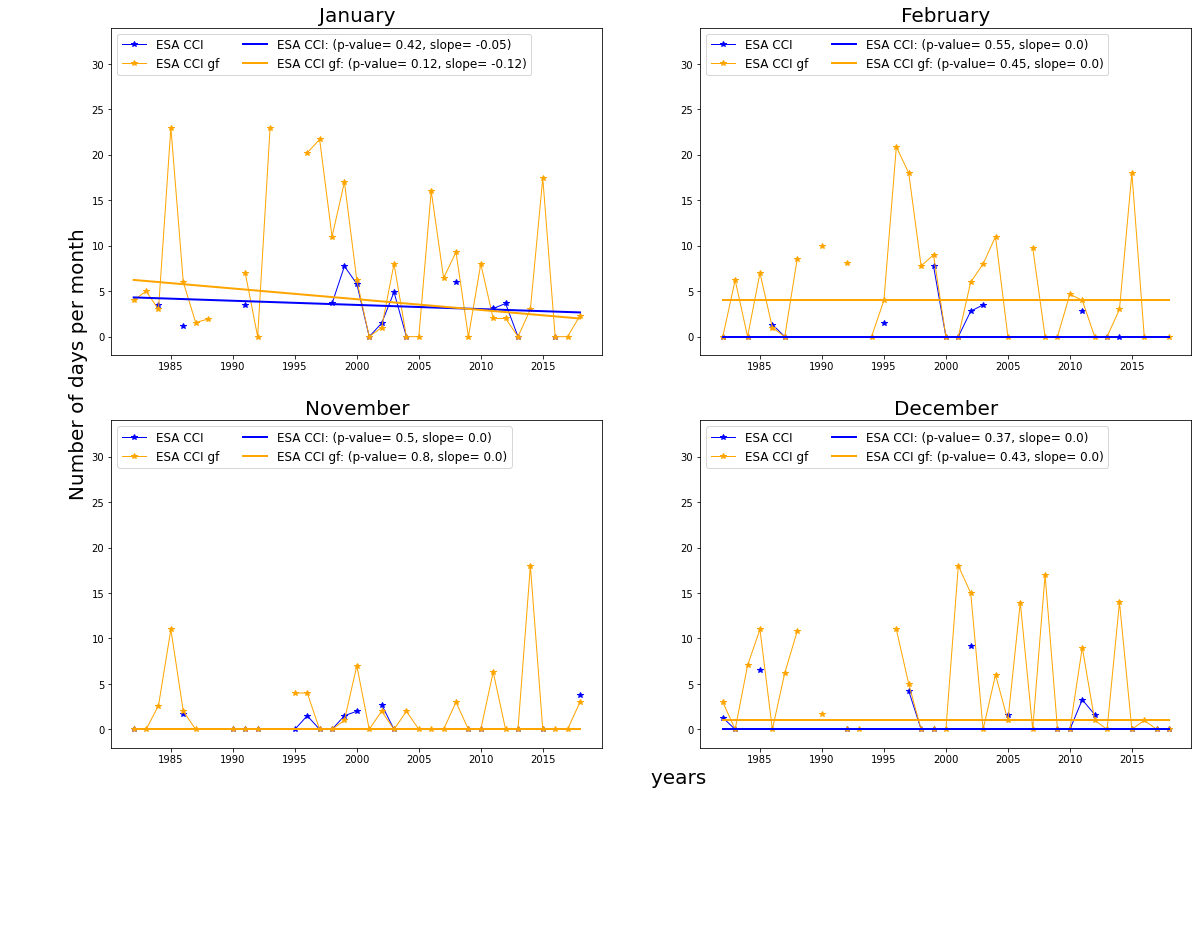

In [94]:
labels_months = ["January", "February", "November", "December"]

fig, axs=plt.subplots(2,2) 

# We fix the spaces between the subfigures
plt.subplots_adjust(wspace=0.2,hspace=0.2)

# We fix the size of figure
set_size(15,10)

mons=[1,2,11,12]
years = [int(y) for y in range(1982,2019)]
index = 0
for i in range(2):
    for j in range(2):
        slope = mk.original_test(TIZ_scfg_Sdays[mons[index]]).slope
        slope_gf = mk.original_test(TIZ_scfg_interp_Sdays[mons[index]]).slope
    
        p = mk.original_test(TIZ_scfg_Sdays[mons[index]]).p
        p_gf = mk.original_test(TIZ_scfg_interp_Sdays[mons[index]]).p

        interc = mk.original_test(TIZ_scfg_Sdays[mons[index]]).intercept
        interc_gf = mk.original_test(TIZ_scfg_interp_Sdays[mons[index]]).intercept

        droit = [slope*k+ interc for k in range(37)]
        droit_gf = [slope_gf*k+ interc_gf for k in range(37)]
        
        droit = pd.DataFrame({'year': years, 'N': droit})
        droit = droit.set_index('year')
    
        droit_gf = pd.DataFrame({'year': years, 'N': droit_gf})
        droit_gf = droit_gf.set_index('year')
    
        labels_legend = ["ESA CCI" ,"ESA CCI gf",
                         "ESA CCI: (p-value= "+str(np.around(p,decimals=2))+", slope= "+str(np.around(slope, decimals=2))+")",
                         "ESA CCI gf: (p-value= "+str(np.around(p_gf, decimals=2))+", slope= "+str(np.around(slope_gf, decimals=2))+")"]
    
    
        TIZ_scfg_Sdays[mons[index]].plot(ax=axs[i][j], color=c1,  linewidth=1, marker='*')
        TIZ_scfg_interp_Sdays[mons[index]].plot(ax=axs[i][j], color=c2, marker='*', linewidth=1)
        
        droit.plot(ax=axs[i][j], ylim=[-2,34], color=c1,  linewidth=2)
        droit_gf.plot(ax=axs[i][j], ylim=[-2,34], color=c2,  linewidth=2)
    
        axs[i][j].set_title(labels_months[index], fontsize=20)
        axs[i][j].set_xlabel("")
        axs[i][j].legend(labels = labels_legend, loc='upper left', ncol=2, fontsize=12)
        axs[i][j].set_ylabel("") 
        axs[i][j].set_ylim(-2,34)
        
        index = index + 1

axs[1][0].set_xlabel("                                                                                                     years", fontsize=20)
axs[1][0].set_ylabel("                                                                     Number of days per month", fontsize=20)

plt.savefig('TIZ_comparison_trend.png') 

<h1 style="font-size:1.5rem; color:green;"> Oukaimeden </h1>

Text(0, 0.5, '                                                                     Number of days per month')

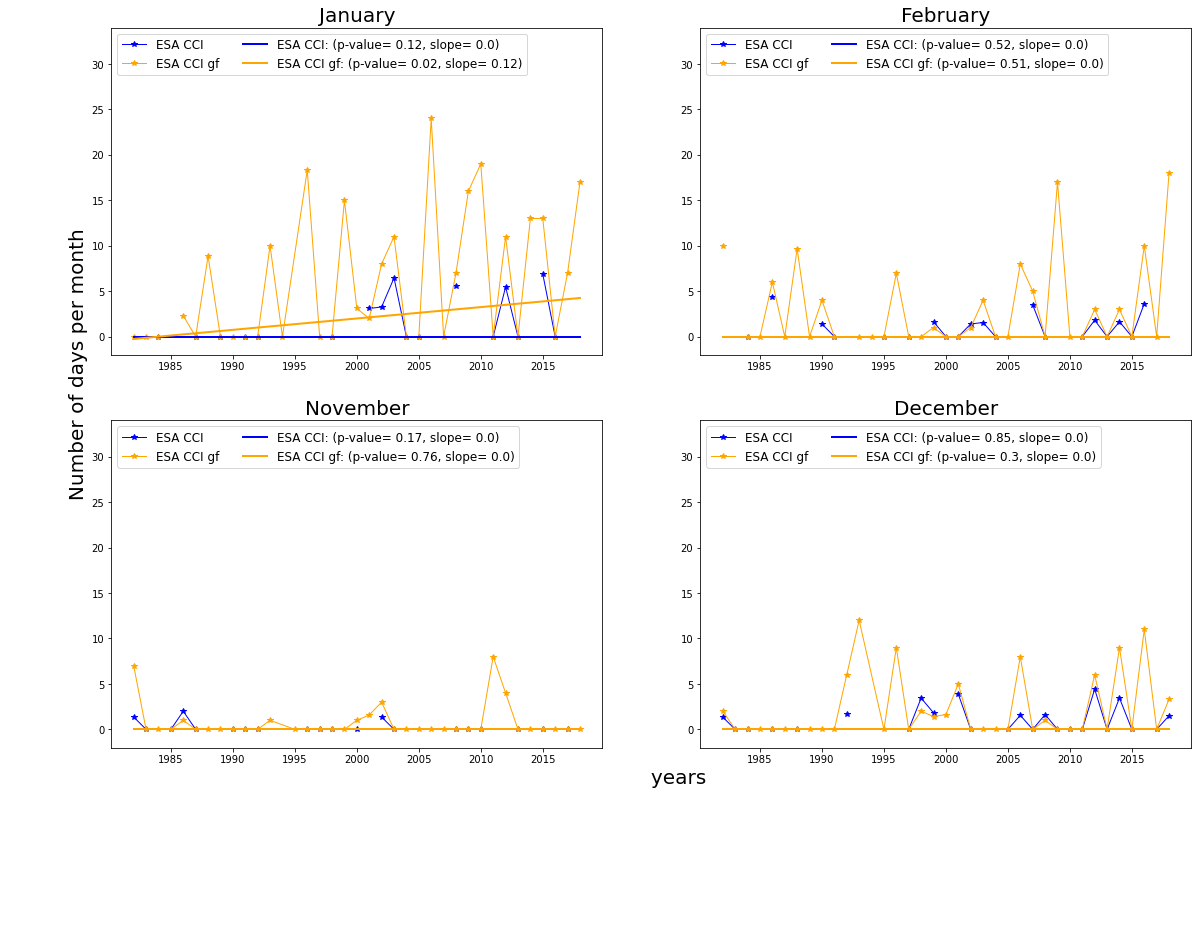

In [95]:
labels_months = ["January", "February", "November", "December"]

fig, axs=plt.subplots(2,2) 

# We fix the spaces between the subfigures
plt.subplots_adjust(wspace=0.2,hspace=0.2)

# We fix the size of figure
set_size(15,10)

mons=[1,2,11,12]
years = [int(y) for y in range(1982,2019)]
index = 0
for i in range(2):
    for j in range(2):
        slope = mk.original_test(OUK_scfg_Sdays[mons[index]]).slope
        slope_gf = mk.original_test(OUK_scfg_interp_Sdays[mons[index]]).slope
    
        p = mk.original_test(OUK_scfg_Sdays[mons[index]]).p
        p_gf = mk.original_test(OUK_scfg_interp_Sdays[mons[index]]).p

        interc = mk.original_test(OUK_scfg_Sdays[mons[index]]).intercept
        interc_gf = mk.original_test(OUK_scfg_interp_Sdays[mons[index]]).intercept

        droit = [slope*k+ interc for k in range(37)]
        droit_gf = [slope_gf*k+ interc_gf for k in range(37)]
        
        droit = pd.DataFrame({'year': years, 'N': droit})
        droit = droit.set_index('year')
    
        droit_gf = pd.DataFrame({'year': years, 'N': droit_gf})
        droit_gf = droit_gf.set_index('year')
    
        labels_legend = ["ESA CCI" ,"ESA CCI gf",
                         "ESA CCI: (p-value= "+str(np.around(p,decimals=2))+", slope= "+str(np.around(slope, decimals=2))+")",
                         "ESA CCI gf: (p-value= "+str(np.around(p_gf, decimals=2))+", slope= "+str(np.around(slope_gf, decimals=2))+")"]
    
    
        OUK_scfg_Sdays[mons[index]].plot(ax=axs[i][j], color=c1,  linewidth=1, marker='*')
        OUK_scfg_interp_Sdays[mons[index]].plot(ax=axs[i][j], color=c2, marker='*', linewidth=1)
        
        droit.plot(ax=axs[i][j], ylim=[-2,34], color=c1,  linewidth=2)
        droit_gf.plot(ax=axs[i][j], ylim=[-2,34], color=c2,  linewidth=2)
    
        axs[i][j].set_title(labels_months[index], fontsize=20)
        axs[i][j].set_xlabel("")
        axs[i][j].legend(labels = labels_legend, loc='upper left', ncol=2, fontsize=12)
        axs[i][j].set_ylabel("") 
        axs[i][j].set_ylim(-2,34)
        
        index = index + 1

axs[1][0].set_xlabel("                                                                                                     years", fontsize=20)
axs[1][0].set_ylabel("                                                                     Number of days per month", fontsize=20)

plt.savefig('OUK_comparison_trend.png') 